In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.0 MB/s eta 0:00:00a 0:00:01


In [2]:
import numpy as np
import torch
import torch_geometric
import h5py
import matplotlib.pyplot as plt

from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_geometric.nn import global_mean_pool
from torch.nn import Linear

In [3]:
Data_Path = '/kaggle/input/paraquet-df/quark-gluon_data-set_n139306.hdf5'
Data_Size = 40000
k = 8

In [4]:
import h5py
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph

def load_data(k=8, max_nodes=800, activation_threshold=1e-3):
    # Adding coordinates to the featues.
    data = h5py.File(Data_Path, "r")
    images = data['X_jets'][0:Data_Size]
    coords = np.indices((125, 125))
    coords = np.moveaxis(coords, 1, -1).T
    coords = np.expand_dims(coords, axis=0)
    coords = coords.astype(np.float32) / 125.
    coords = np.repeat(coords, Data_Size, axis=0)

    # Surpressing smaller activations
    images[images < activation_threshold] = 0.0
    images_with_coords = np.concatenate((images, coords), axis=-1)

    del coords
    del images
    del data

    data = images_with_coords.reshape((-1, images_with_coords.shape[1] * images_with_coords.shape[2], 5))
    node_list = []

    for i, x in enumerate(data):
        mask = np.any(x[..., :3] != [0., 0., 0.], axis=-1)
        filtered_nodes = x[mask]
        # canonical ordering of nodes.(sorted positions)
        sorted_nodes = filtered_nodes[np.lexsort((filtered_nodes[:, 4], filtered_nodes[:, 3]))]

        if sorted_nodes.shape[0] > max_nodes:
            sorted_nodes = sorted_nodes[:max_nodes]
        
        node_list.append(sorted_nodes)


    dataset = []
    for i, nodes in enumerate(node_list):
        edges = kneighbors_graph(nodes[..., 3:], k, mode='connectivity', include_self=True)
        c = edges.tocoo()
        edge_list = torch.from_numpy(np.vstack((c.row, c.col))).type(torch.long)
        edge_weight = torch.from_numpy(c.data.reshape(-1, 1))
        data = Data(x=torch.from_numpy(nodes), edge_index=edge_list, edge_attr=edge_weight)
        dataset.append(data)
    
    return dataset


In [5]:
dataset = load_data()

In [6]:
train_loader = DataLoader(dataset[:36000], batch_size=64, shuffle=True)
test_loader = DataLoader(dataset[36000:36004], batch_size=1, shuffle=False)

In [108]:
from torch_geometric.nn import SAGEConv, GATConv


# Graph level latent Graph Auto Encoder
class GAE(torch.nn.Module):
  def __init__(self, input_embed_dim : int, latent_dim = None, max_nodes : int = 800):
    super(GAE, self).__init__()
    
    self.node_dim = input_embed_dim
    if latent_dim is None:
      self.latent_dim = self.node_dim
    else:
      self.latent_dim = latent_dim
    self.max_nodes = max_nodes
    self.output_size = self.max_nodes * self.node_dim
    
    self.Conv1 = GATConv(self.node_dim, self.latent_dim, heads=1, concat=False)
    self.Conv2 = GATConv(self.latent_dim, 2*self.latent_dim, heads=1, concat=False)
    self.Conv3 = GATConv(2*self.latent_dim, 4*self.latent_dim, heads=1, concat=False)
    self.Conv4 = GATConv(4*self.latent_dim, 8*self.latent_dim, heads=1, concat=False)
    self.lin1 = torch.nn.Linear(8*self.latent_dim, 16*self.latent_dim)
    self.lin2 = torch.nn.Linear(16*self.latent_dim, 32*self.latent_dim)
    self.lin3 = torch.nn.Linear(32*self.latent_dim, int(self.output_size / 2))
    self.lin4 = torch.nn.Linear(int(self.output_size / 2), self.output_size)
    self.p5 = nn.Dropout(p=0.5)
    self.p3 = nn.Dropout(p=0.3)
    self.p1 = nn.Dropout(p=0.1)
    

  def forward(self, x, edge_index, batch):
    
    # Encoder.
    x = F.relu(self.Conv1(x, edge_index))
    x = F.relu(self.Conv2(x, edge_index))
    x = F.relu(self.Conv3(x, edge_index))
    x = F.relu(self.Conv4(x, edge_index))

    # mask generation and pooling.
    x, mask = torch_geometric.utils.to_dense_batch(x, batch, fill_value=0)
    x = torch.mean(x, dim=1)

    # Decoder  
    x = F.relu(self.lin1(x))
    x = self.p1(x)
    x = F.relu(self.lin2(x))
    x = self.p1(x)
    x = F.relu(self.lin3(x))
    x = self.lin4(x)
    x = torch.reshape(x, (-1, self.max_nodes, self.node_dim))
    new_mask = torch.zeros(mask.shape[0], self.max_nodes, dtype=torch.bool)
    new_mask[:, :mask.shape[1]] = mask
    mask = new_mask
    
    return x, mask

In [109]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [110]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from torchmetrics.image import StructuralSimilarityIndexMeasure

ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0)

def reconstruct_image(features):
    x_coords = (features[:, -2] * 125).cpu().numpy().astype(int)
    y_coords = (features[:, -1] * 125).cpu().numpy().astype(int)
    tracks_act = features[:, 0].cpu().numpy()
    ecal_act = features[:, 1].cpu().numpy()
    hcal_act = features[:, 2].cpu().numpy()

    img_tracks = np.zeros((125, 125))
    img_ecal = np.zeros((125, 125))
    img_hcal = np.zeros((125, 125))

    for i in range(len(x_coords)):
        if 0 <= x_coords[i] < 125 and 0 <= y_coords[i] < 125:
            img_tracks[y_coords[i], x_coords[i]] = tracks_act[i]
            img_ecal[y_coords[i], x_coords[i]] = ecal_act[i]
            img_hcal[y_coords[i], x_coords[i]] = hcal_act[i]

    # Stack the channels to get a 3-channel image
    image = np.stack([img_tracks, img_ecal, img_hcal], axis=0)
    return torch.tensor(image, dtype=torch.float32).unsqueeze(0) / np.max(image)
    
def calculate_ssim(data, x):
    original_image = reconstruct_image(data)
    reconstructed_image = reconstruct_image(x)

    # Ensure both images are in the correct format
    original_image = original_image.clamp(0, 1)
    reconstructed_image = reconstructed_image.clamp(0, 1)

    ssim_score = ssim_metric(reconstructed_image, original_image)
    return ssim_score.item()

In [123]:
# Graph features based reconstruction loss.
def weighted_mse_loss(output, target, mask):
    weights = torch.tensor([1.0, 1.0, 1.0], device=output.device)
    squared_error = (output - target) ** 2
    for i in range(0, 3):
        squared_error[:,:,i] = squared_error[:,:,i] * weights[i]
    # Apply mask to the loss
    masked_error = squared_error * mask.unsqueeze(-1).to(device)
    loss = masked_error.sum() / (mask.sum() + 1e-8)  # Prevent division by zero
    return loss

In [124]:
def visualize(data):
    x = data[:,3]
    y = data[:,4]
    tracks_act = data[:,0]
    hcal_act = data[:,2]
    ecal_act = data[:,1]
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].set_xlim(0, 1)  # Force x-axis to show 0-1 range
    axs[0].set_ylim(0, 1)
    # Plot tracks_act
    axs[0].scatter(x, y, c=tracks_act, s= torch.abs(tracks_act) * 500, cmap='inferno', alpha=0.5)
    axs[0].set_title('Tracks Activity')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')

    axs[1].set_xlim(0, 1)  # Force x-axis to show 0-1 range
    axs[1].set_ylim(0, 1)
    # Plot ecal_act
    axs[1].scatter(x, y,  c=ecal_act, s= torch.abs(ecal_act) * 500, cmap='inferno', alpha=0.5)
    axs[1].set_title('Ecal Activity')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')

    axs[2].set_xlim(0, 1)  # Force x-axis to show 0-1 range
    axs[2].set_ylim(0, 1)
    # Plot hcal_act
    axs[2].scatter(x, y, c=hcal_act, s= torch.abs(hcal_act) * 500, cmap='inferno', alpha=0.5)
    axs[2].set_title('Hcal Activity')
    axs[2].set_xlabel('X')
    axs[2].set_ylabel('Y')


    plt.tight_layout()
    plt.show()

In [125]:
from tqdm import tqdm

def train():
    model.train()
    total_loss = 0

    with tqdm(train_loader, desc="Training", leave=False) as t:
        for data in t:
            data = data.to(device)
            out, mask = model(data.x, data.edge_index, data.batch)
            x,_ = torch_geometric.utils.to_dense_batch(data.x, data.batch, fill_value=0)
            pad_size = model.max_nodes - x.shape[1]
            if (pad_size > 0):
                x = F.pad(x, (0, 0, 0, pad_size, 0, 0))
            loss = weighted_mse_loss(out, x, mask)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
            t.set_postfix(loss=loss.item())
        return total_loss / 64.

In [126]:
def inference(model, data_loader, device):
    model.eval()
    all_outputs = []
    
    with torch.no_grad():
        with tqdm(data_loader, desc="Inference", leave=False) as t:
            for data in t:
                data = data.to(device)
                out, mask = model(data.x, data.edge_index, data.batch)
                # Convert input to dense and pad if necessary
                x, _ = torch_geometric.utils.to_dense_batch(data.x, data.batch, fill_value=0)
                visualize(x[0].cpu())
                visualize(out[0][:data.x.shape[0]].cpu())
                ssim_score = calculate_ssim(data.x, out[0][:data.x.shape[0]])
                print(f"SSIM Score: {ssim_score}")
                # Save output and mask for further analysis
                all_outputs.append((out.cpu(), mask.cpu()))
                
    return all_outputs

Epoch :  1  Loss :  0.4885169903864153


Epoch :  2  Loss :  0.4273867362062447


Epoch :  3  Loss :  0.41587010002695024


Epoch :  4  Loss :  0.41350331372814253


Epoch :  5  Loss :  0.406645750394091


Epoch :  6  Loss :  0.4042461492936127


Epoch :  7  Loss :  0.3997525214217603


Epoch :  8  Loss :  0.3953606700524688


Epoch :  9  Loss :  0.3950712438672781


Inference:   0%|          | 0/4 [00:00<?, ?it/s]                        

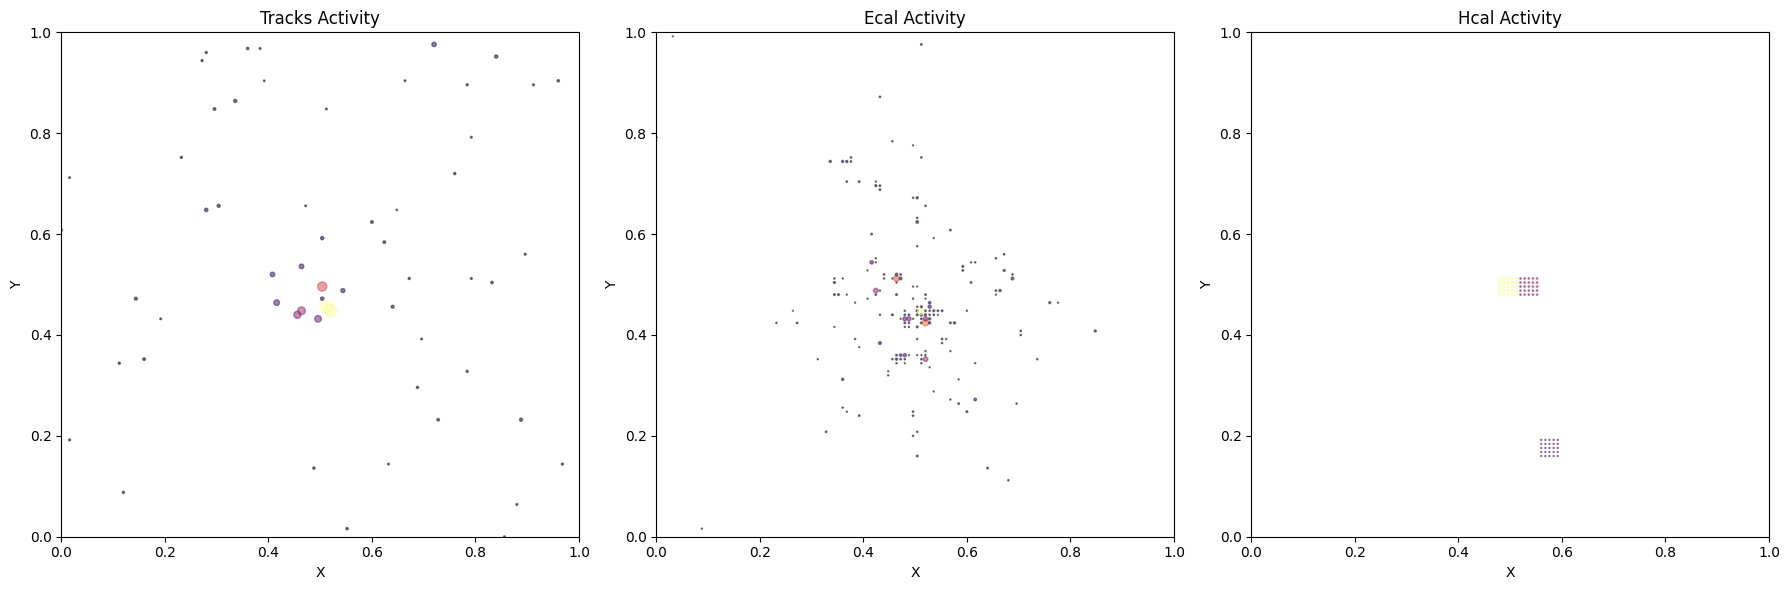

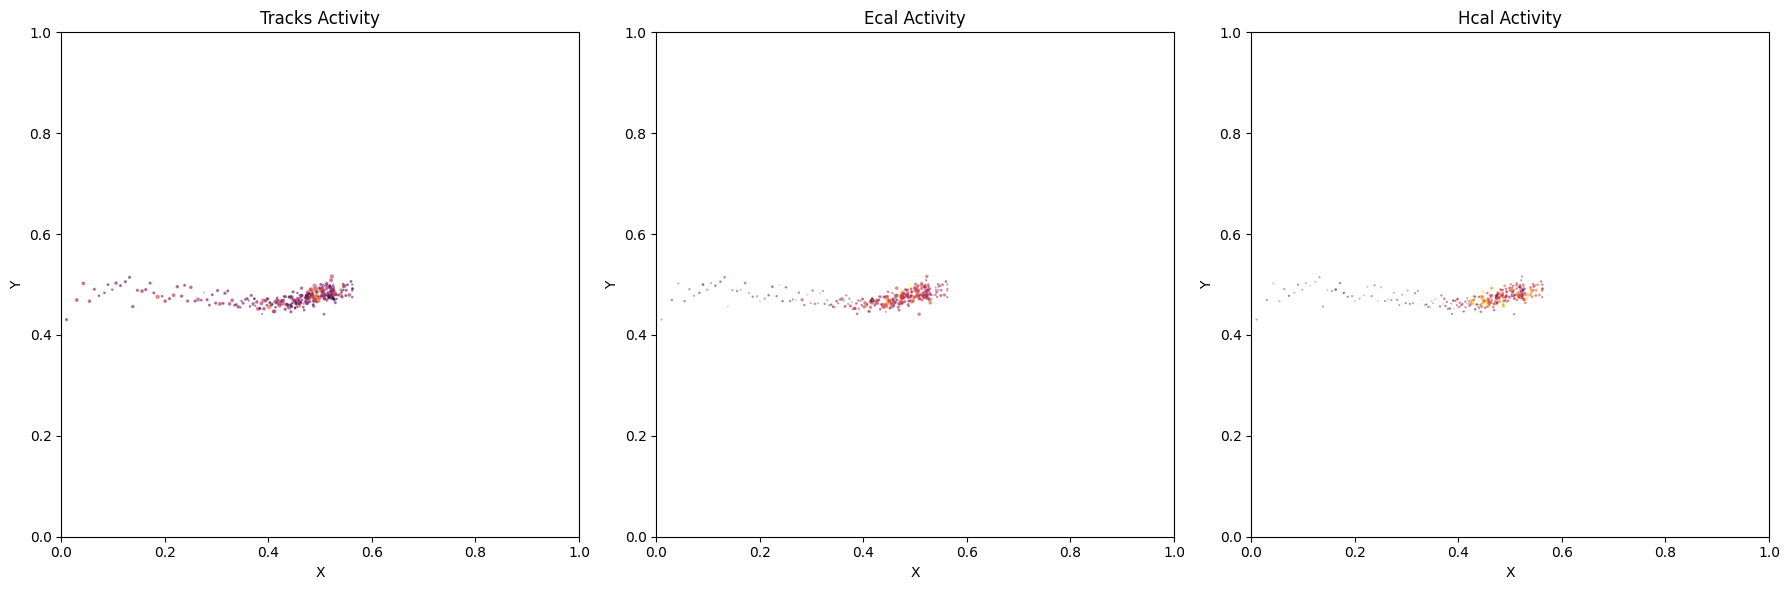

Inference:  25%|██▌       | 1/4 [00:01<00:03,  1.12s/it]

SSIM Score: 0.9650533199310303


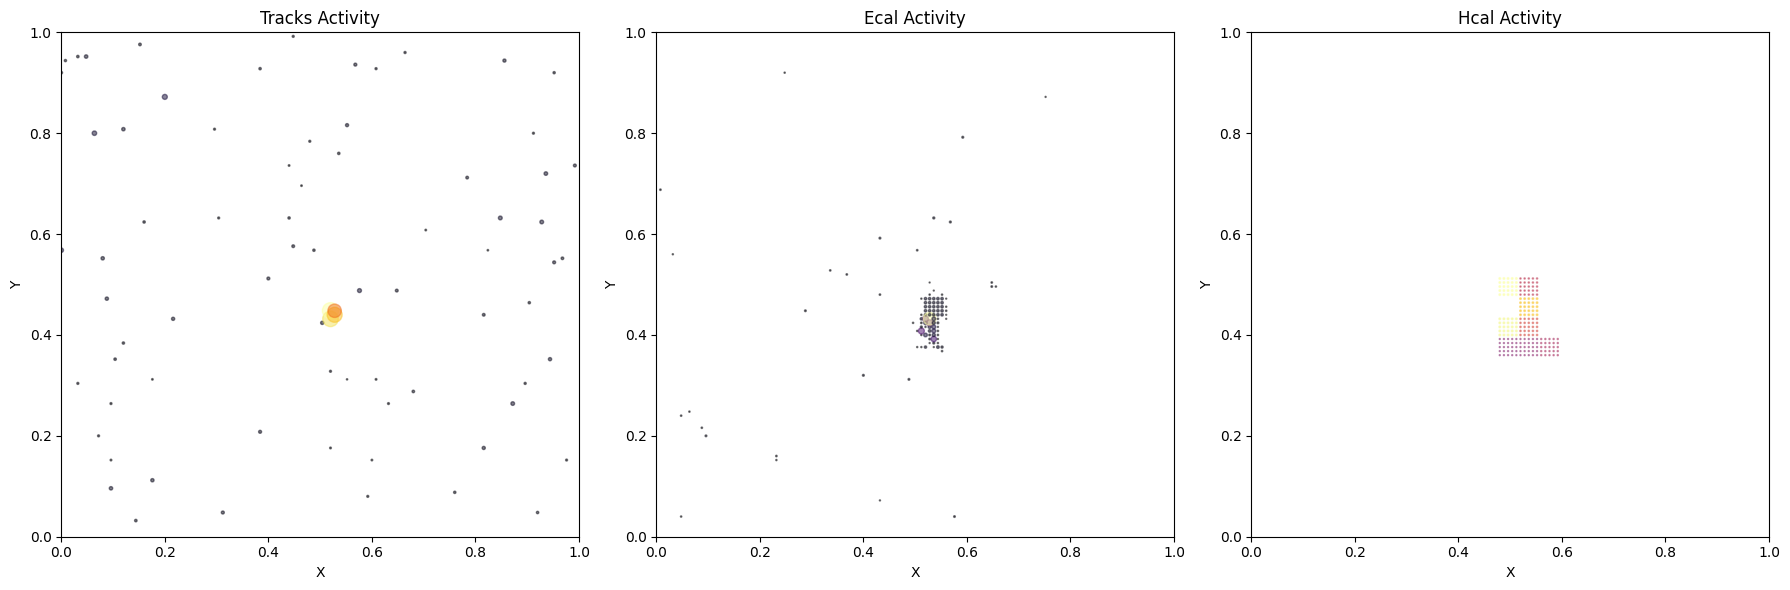

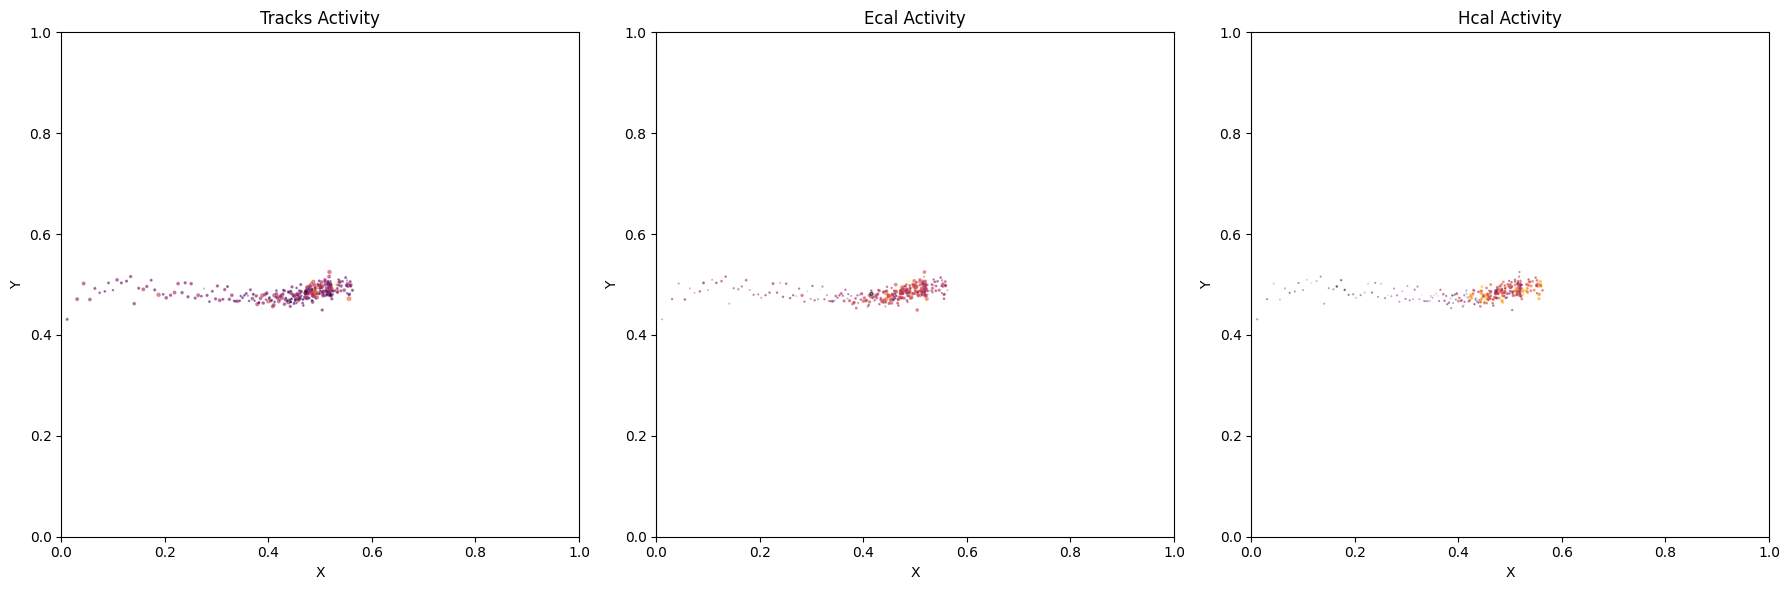

Inference:  50%|█████     | 2/4 [00:02<00:02,  1.10s/it]

SSIM Score: 0.9667884707450867


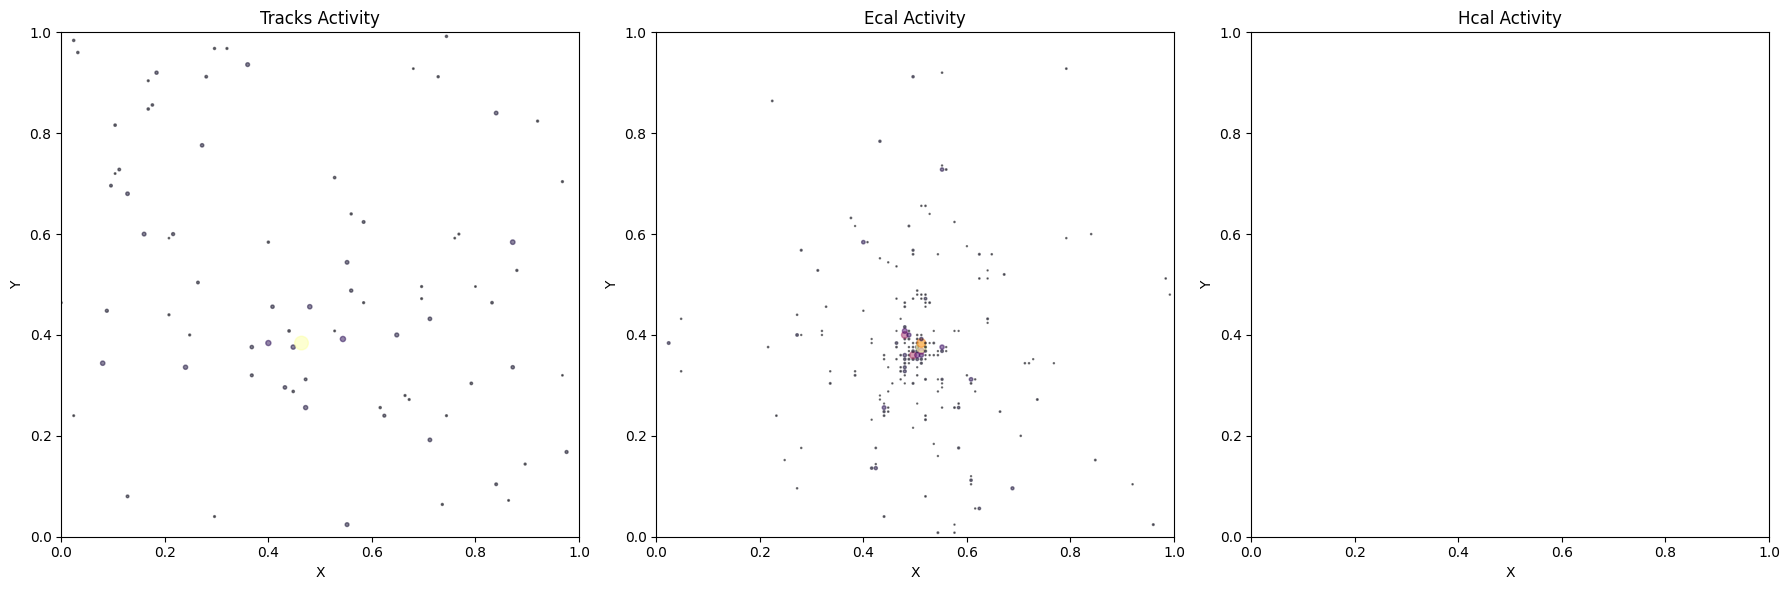

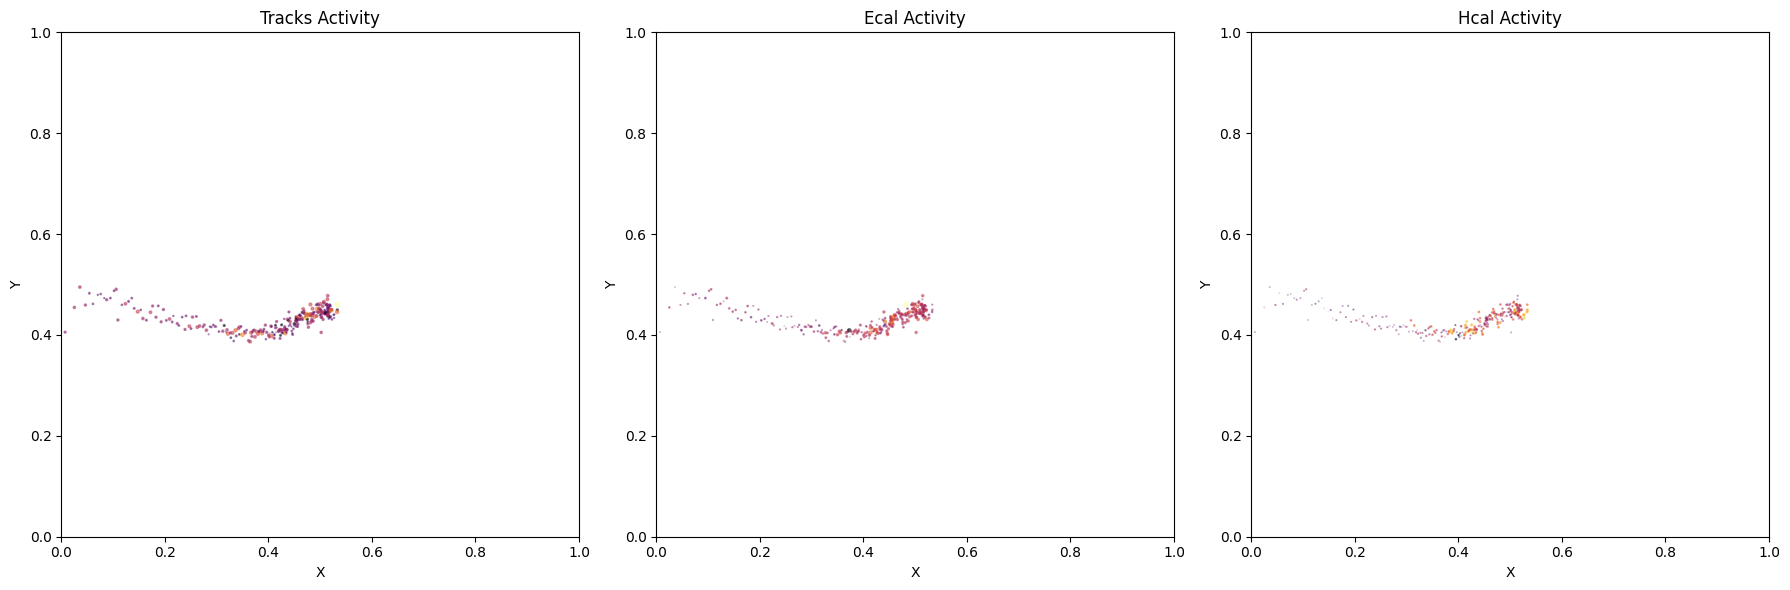

Inference:  75%|███████▌  | 3/4 [00:03<00:01,  1.09s/it]

SSIM Score: 0.9605690836906433


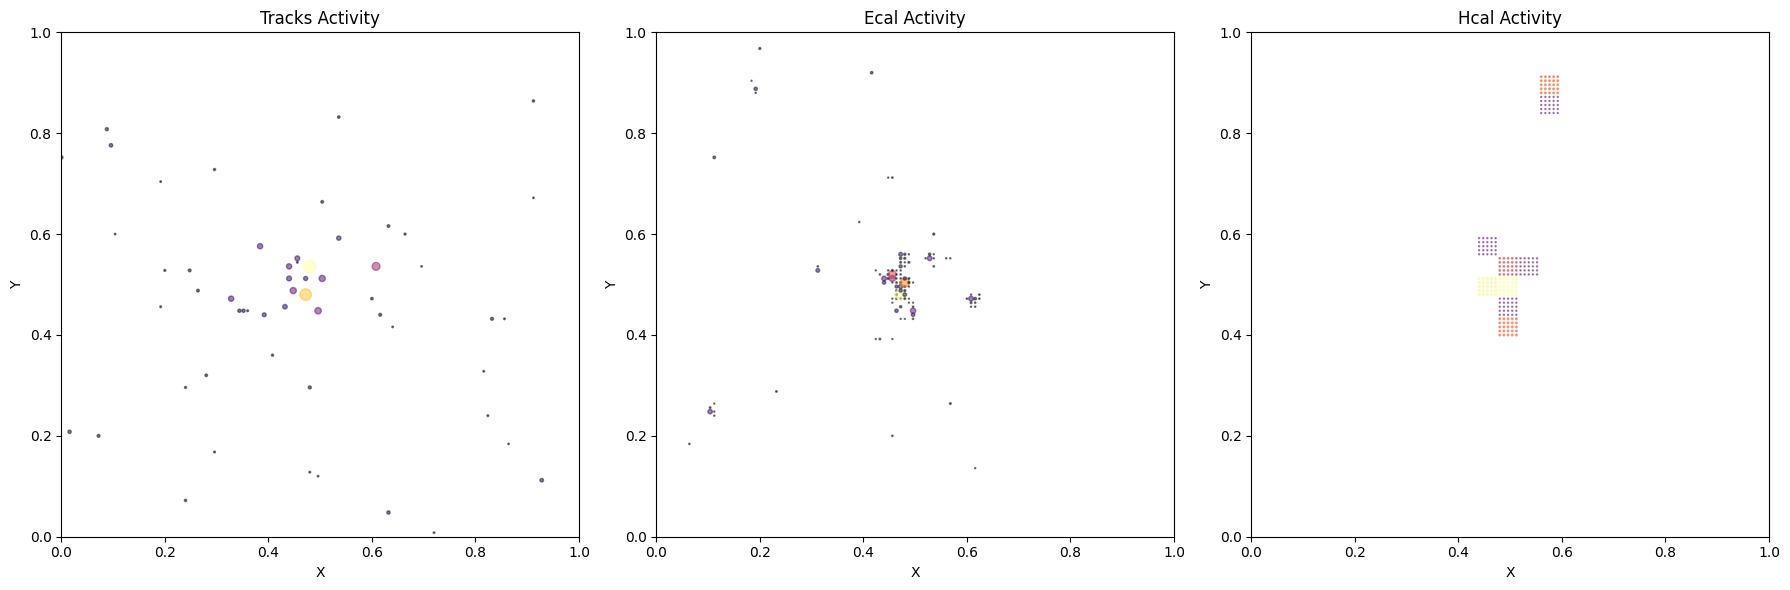

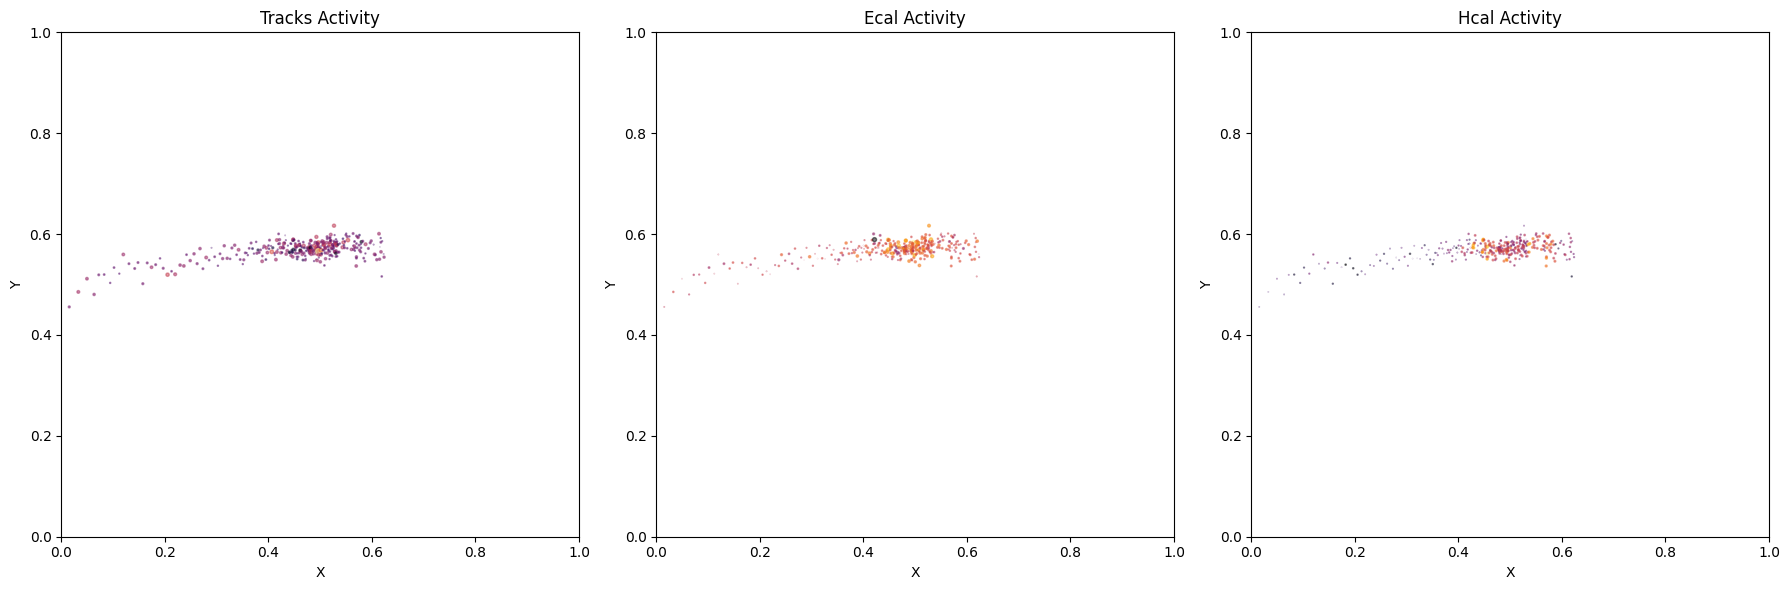

SSIM Score: 0.9466950297355652
Epoch :  10  Loss :  0.3924267978873104


Epoch :  11  Loss :  0.3910132232122123


Epoch :  12  Loss :  0.39108332118485123


Epoch :  13  Loss :  0.3865274336421862


Epoch :  14  Loss :  0.38521769584622234


Epoch :  15  Loss :  0.3847420209203847


Epoch :  16  Loss :  0.3834813795401715


Epoch :  17  Loss :  0.3829147926880978


Epoch :  18  Loss :  0.38055123237427324


Epoch :  19  Loss :  0.37853219045791775


Inference:   0%|          | 0/4 [00:00<?, ?it/s]                        

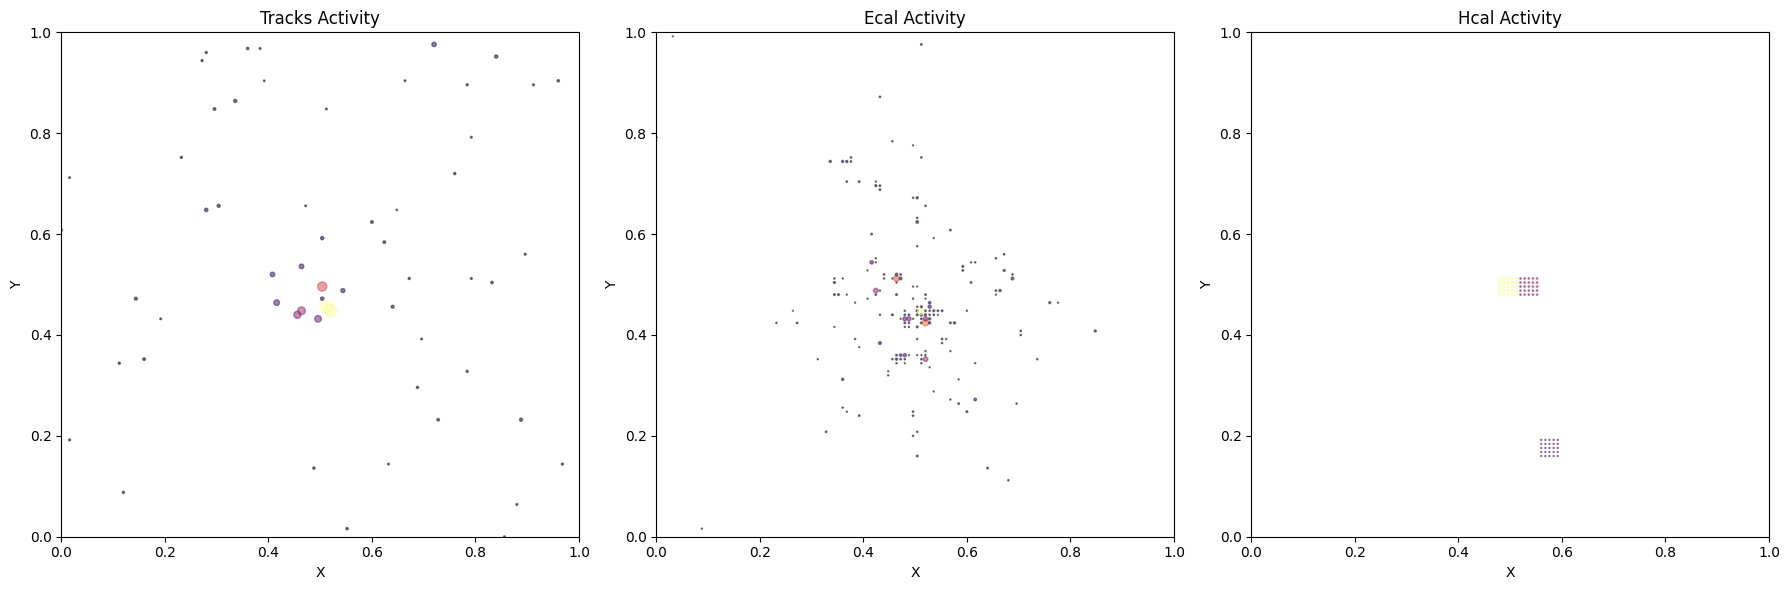

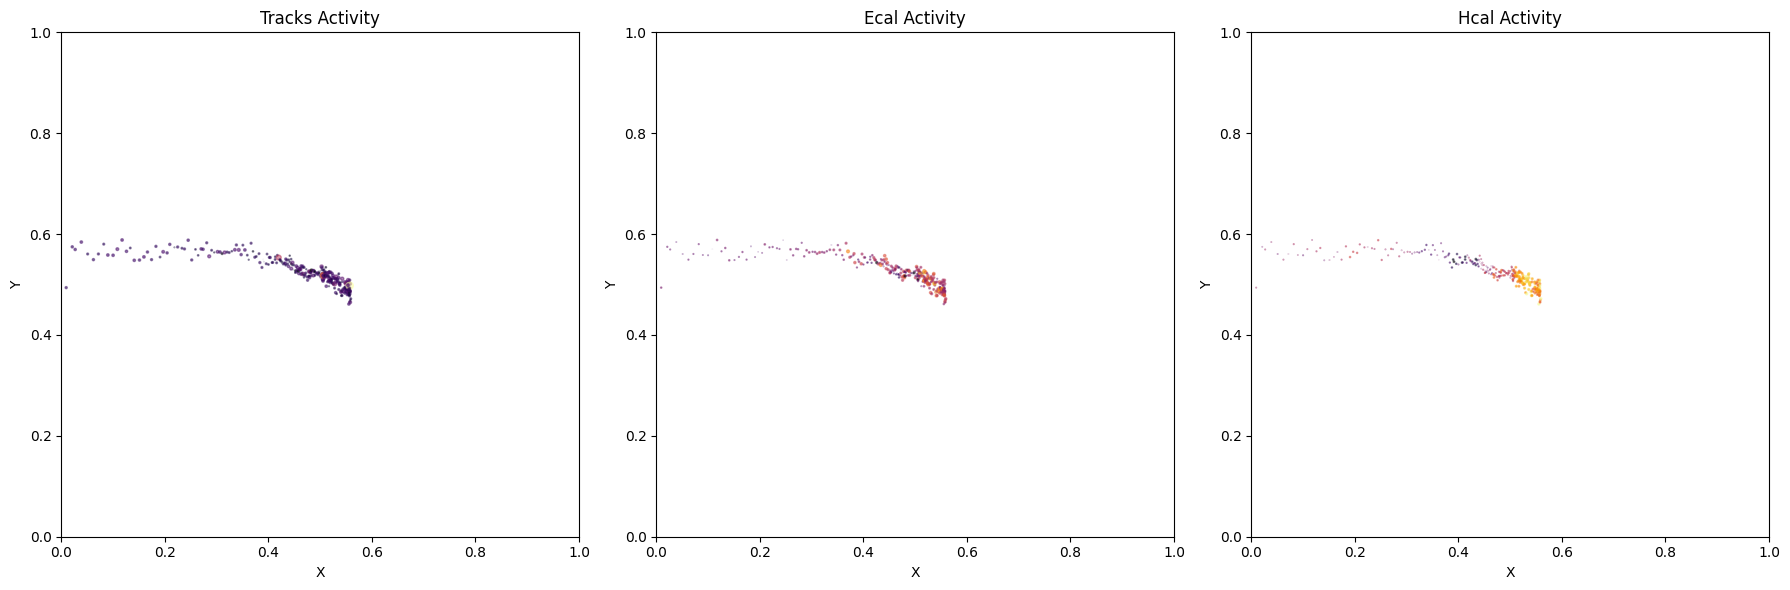

Inference:  25%|██▌       | 1/4 [00:01<00:03,  1.19s/it]

SSIM Score: 0.9642724990844727


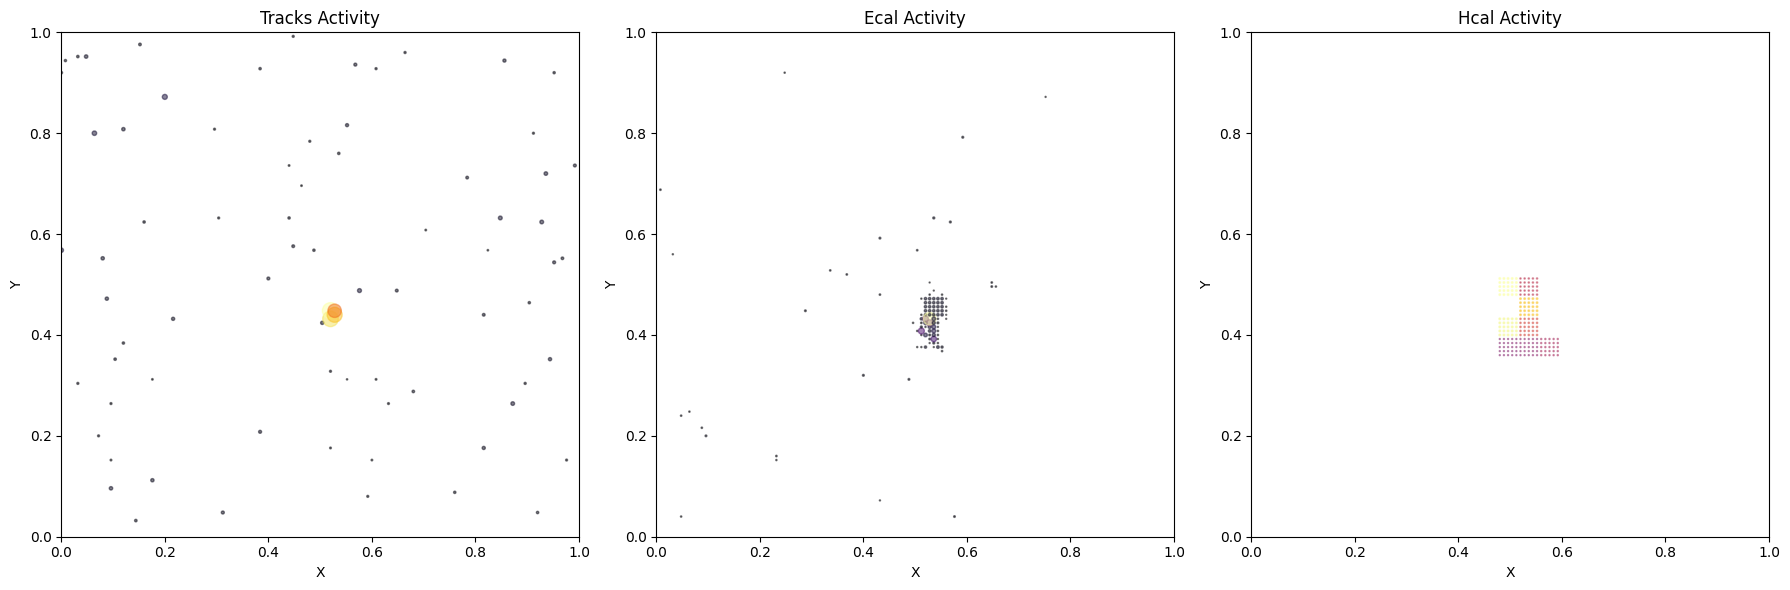

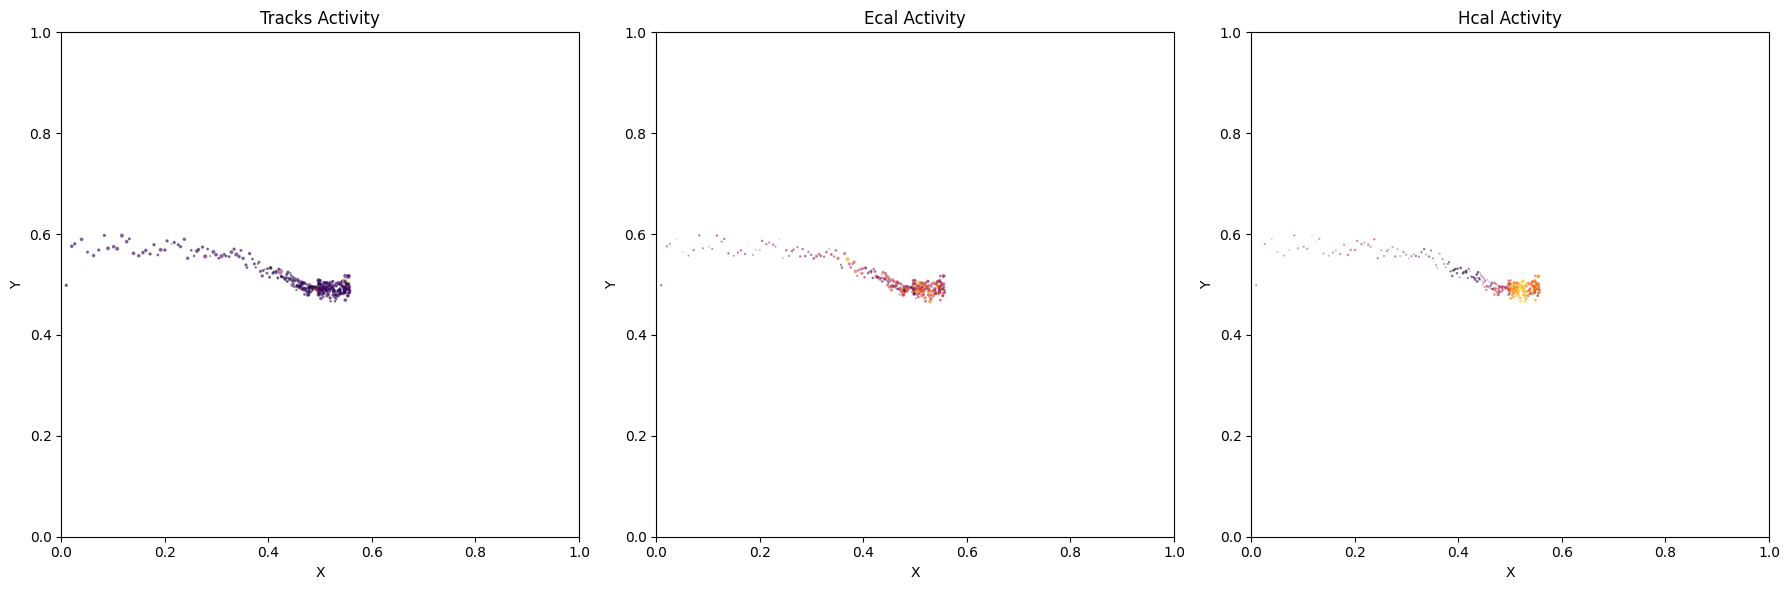

Inference:  50%|█████     | 2/4 [00:02<00:02,  1.46s/it]

SSIM Score: 0.9665165543556213


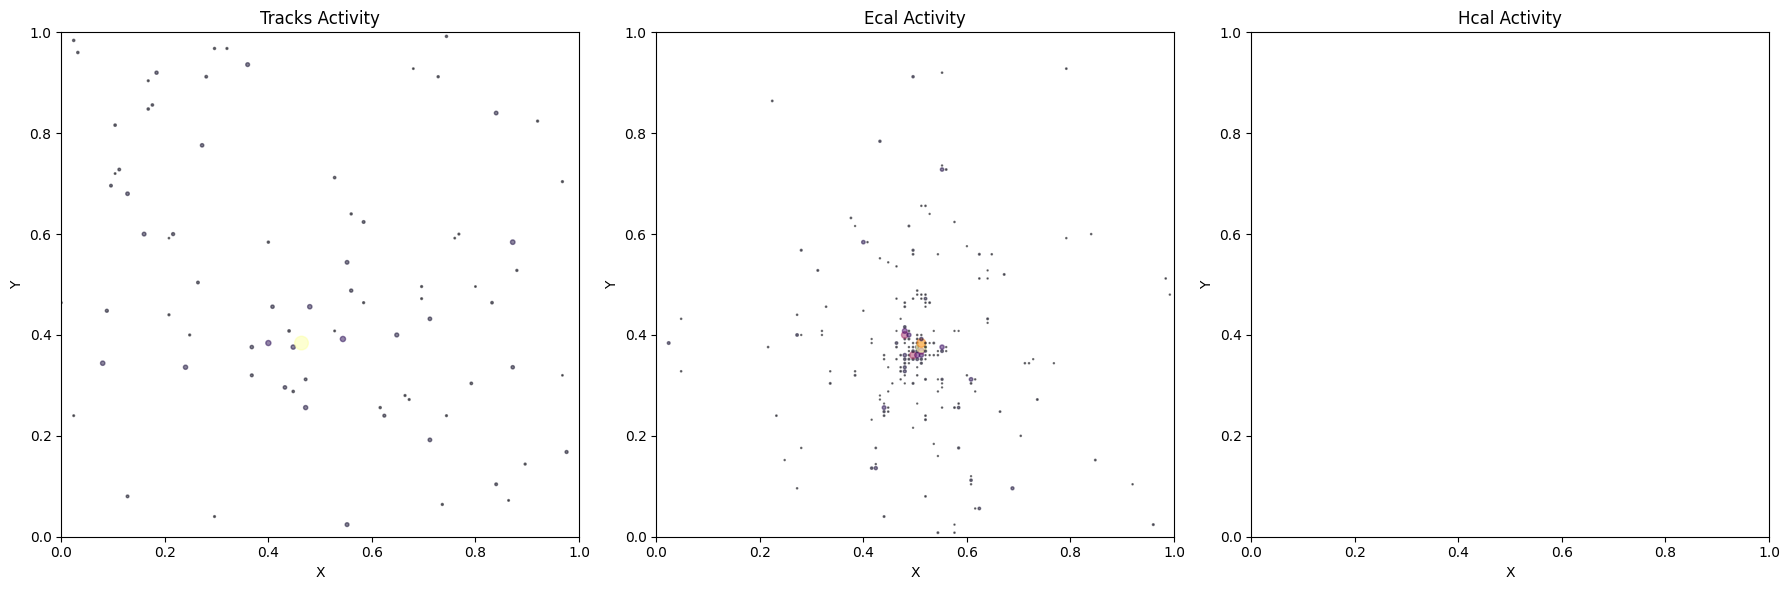

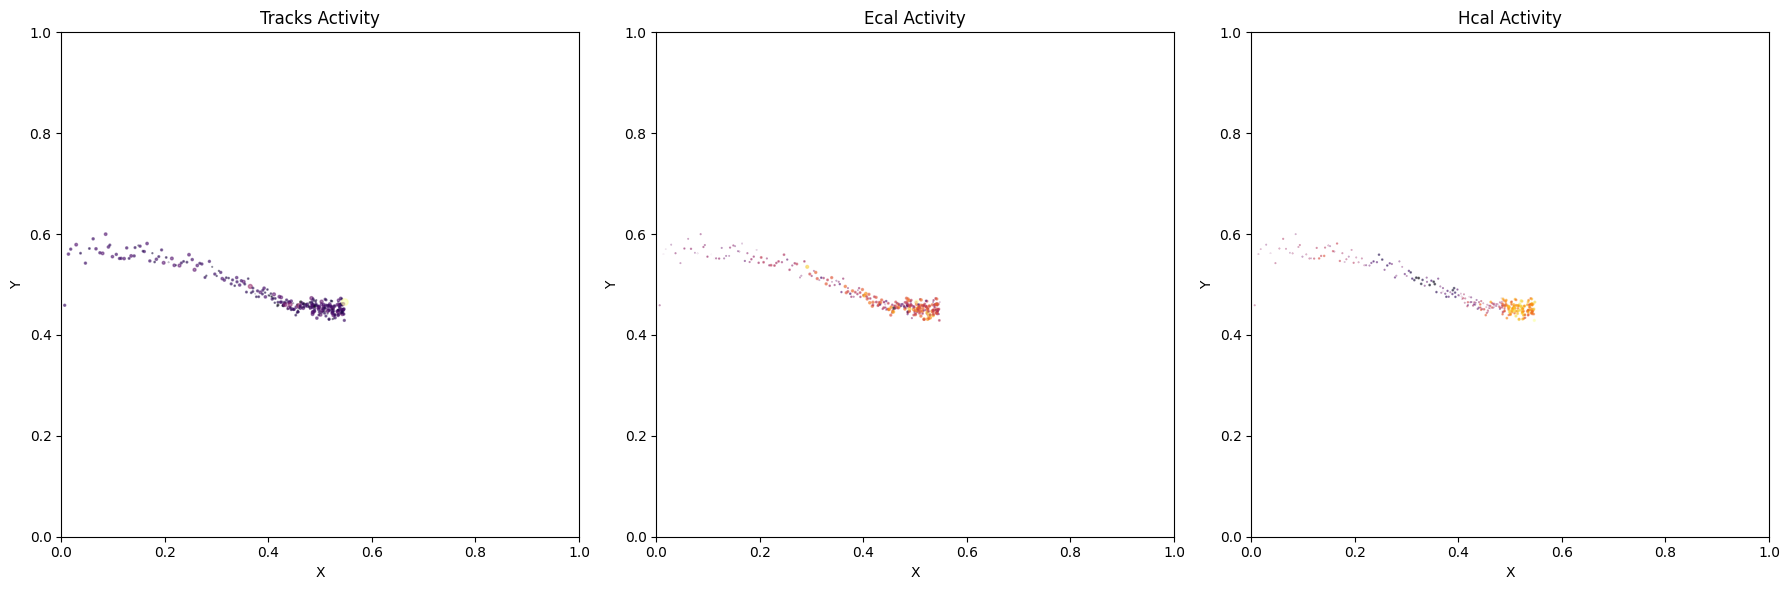

Inference:  75%|███████▌  | 3/4 [00:03<00:01,  1.31s/it]

SSIM Score: 0.9693546891212463


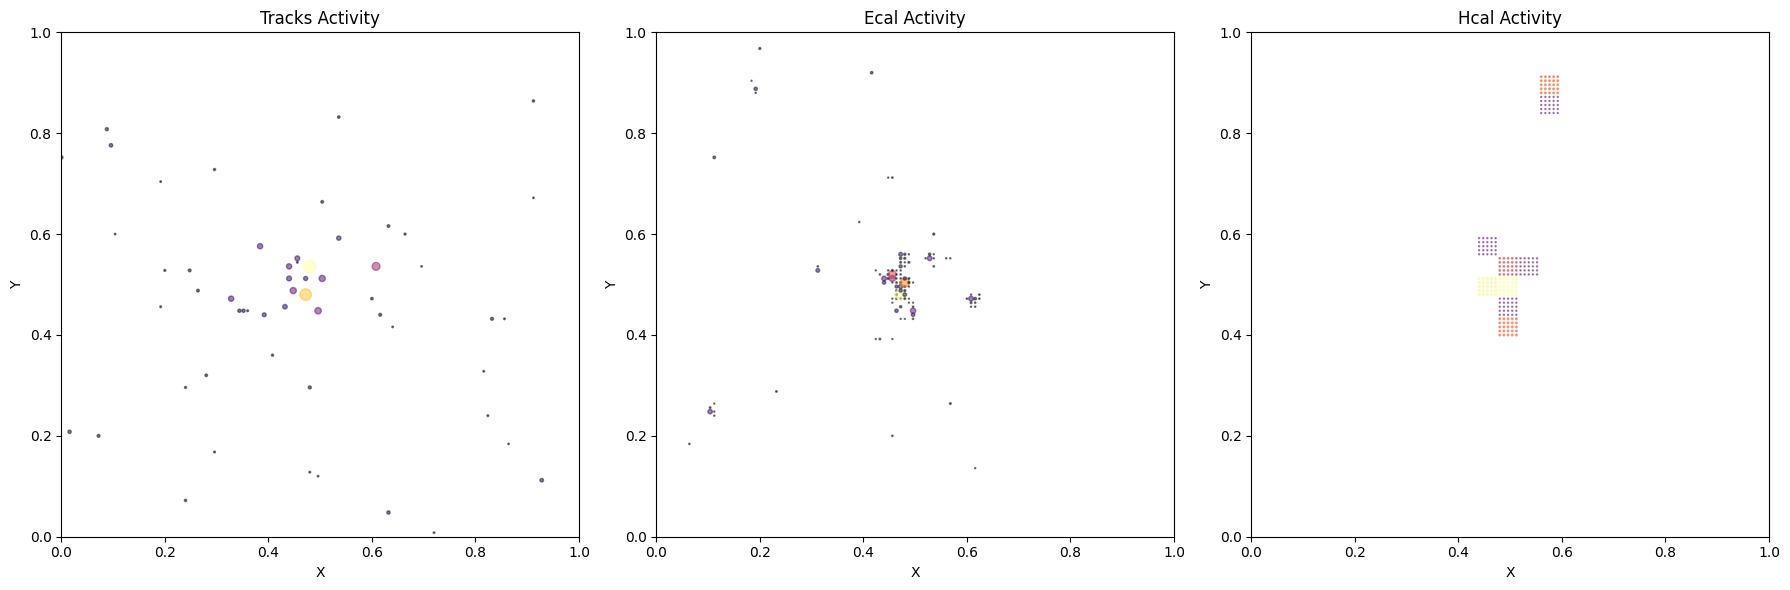

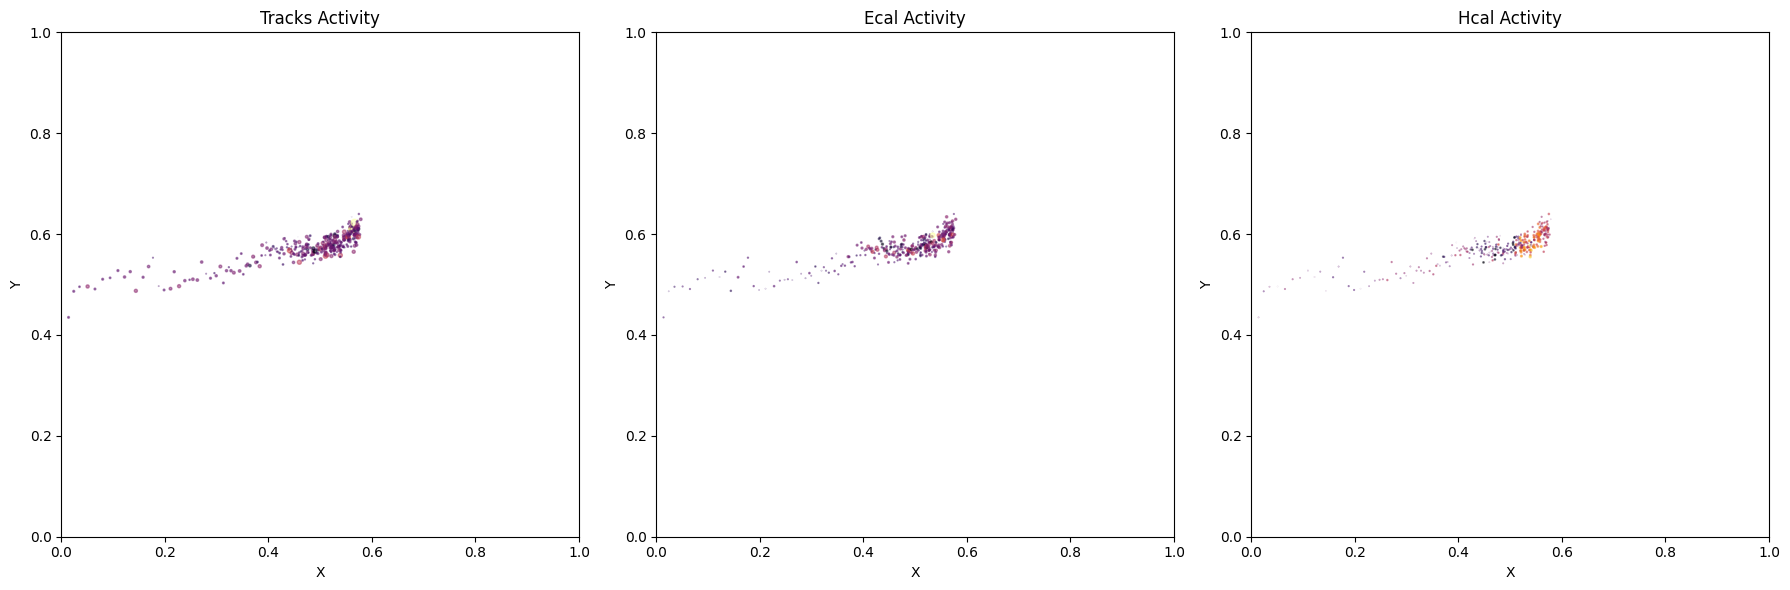

SSIM Score: 0.9679346084594727
Epoch :  20  Loss :  0.37936603714479133


Epoch :  21  Loss :  0.3773382002254948


Epoch :  22  Loss :  0.3752671583206393


Epoch :  23  Loss :  0.37536795635242015


Epoch :  24  Loss :  0.37367189454380423


Epoch :  25  Loss :  0.37270672514569014


Epoch :  26  Loss :  0.37280520843341947


Epoch :  27  Loss :  0.37045288959052414


Epoch :  28  Loss :  0.3714130853768438


Epoch :  29  Loss :  0.3689171593869105


Inference:   0%|          | 0/4 [00:00<?, ?it/s]                        

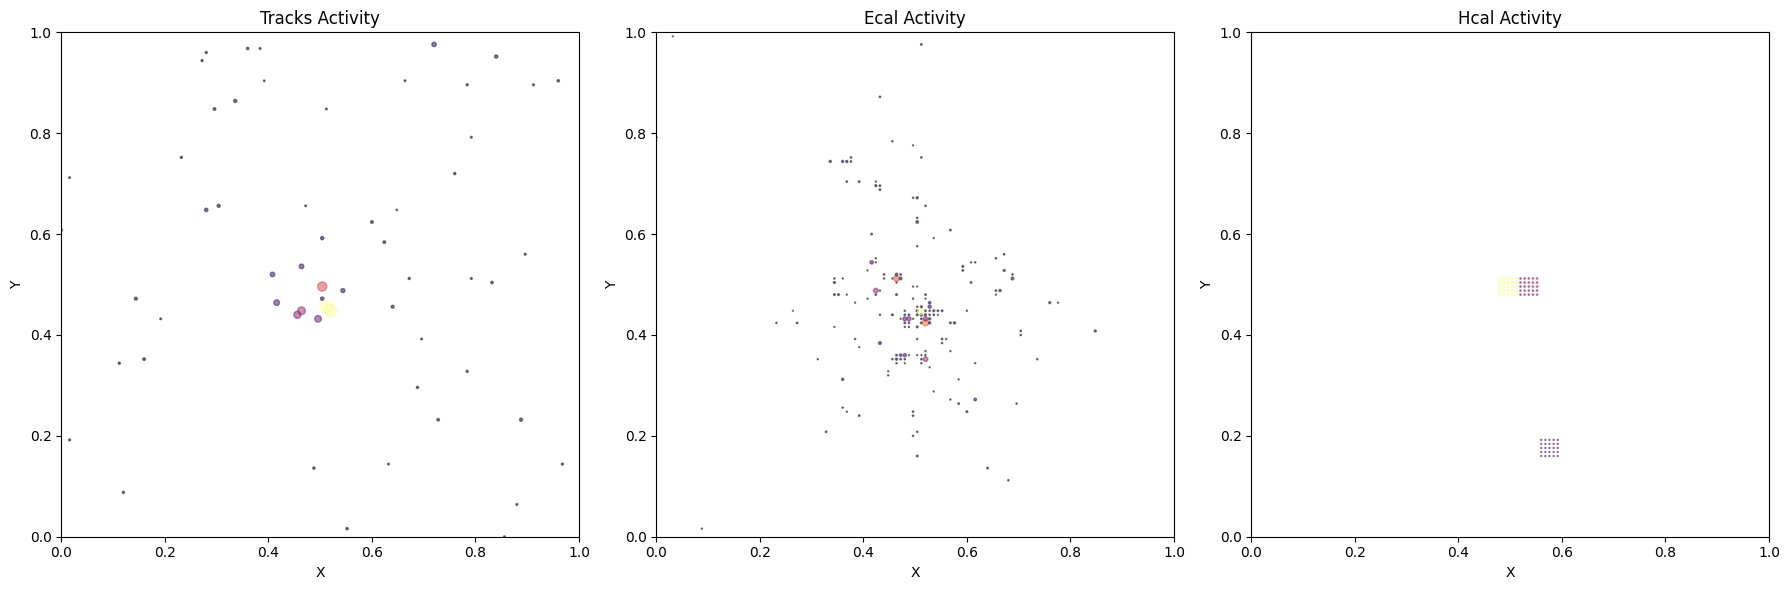

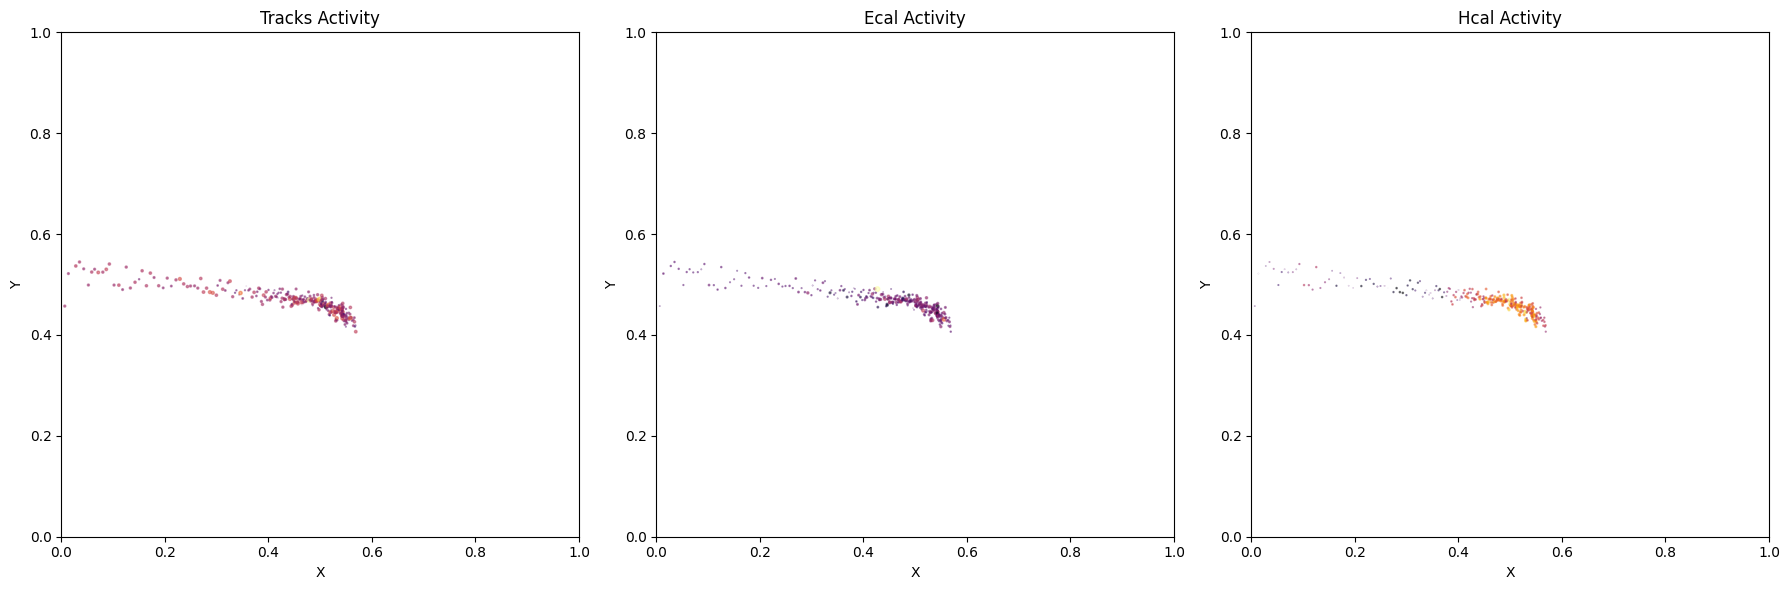

Inference:  25%|██▌       | 1/4 [00:01<00:03,  1.10s/it]

SSIM Score: 0.9636886119842529


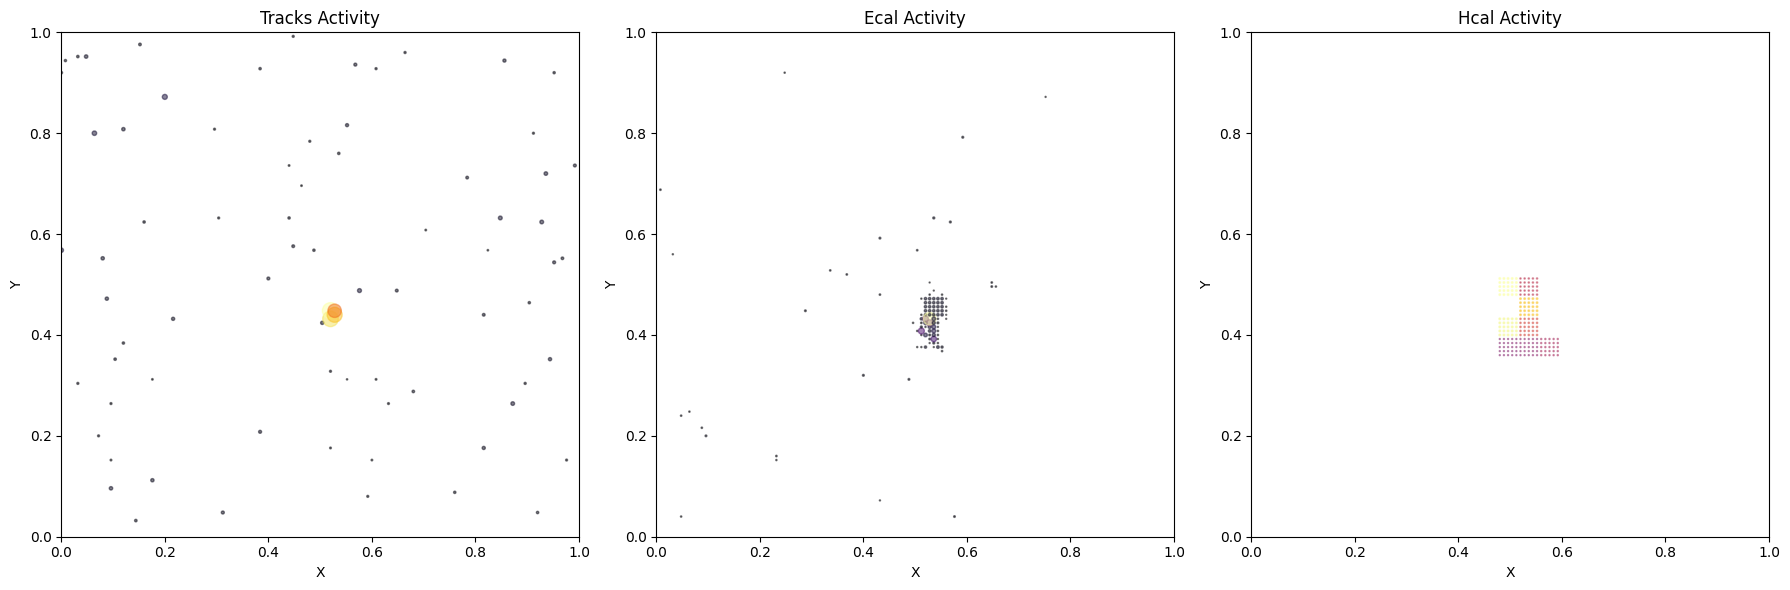

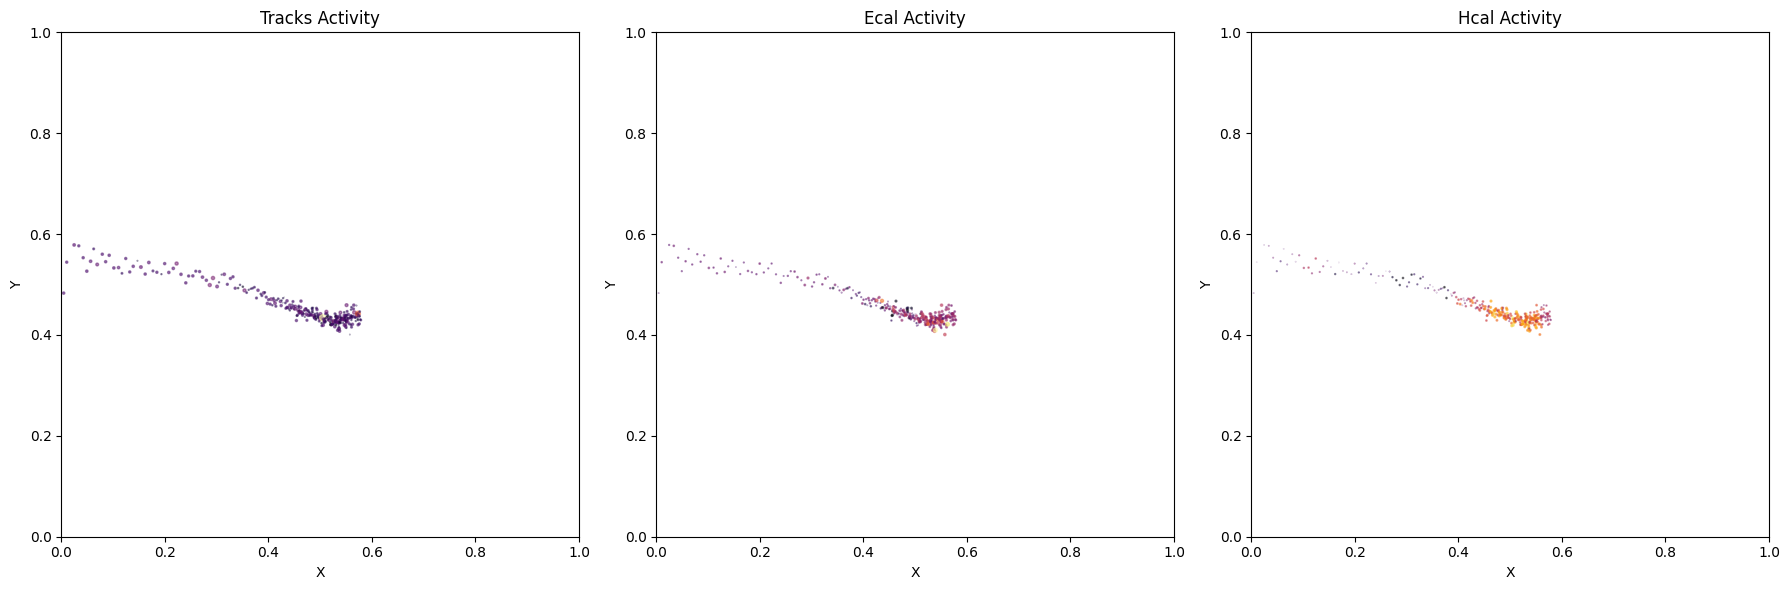

Inference:  50%|█████     | 2/4 [00:02<00:02,  1.13s/it]

SSIM Score: 0.9673603177070618


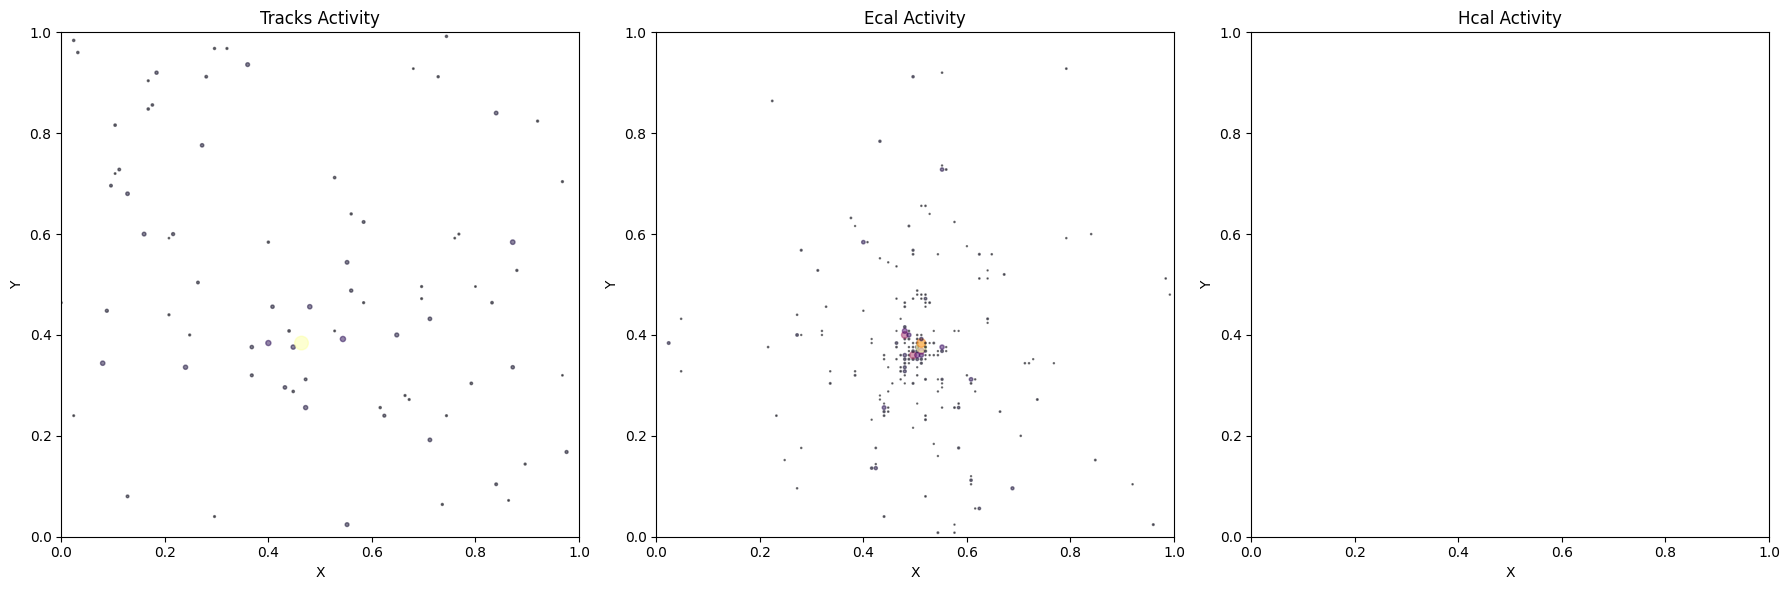

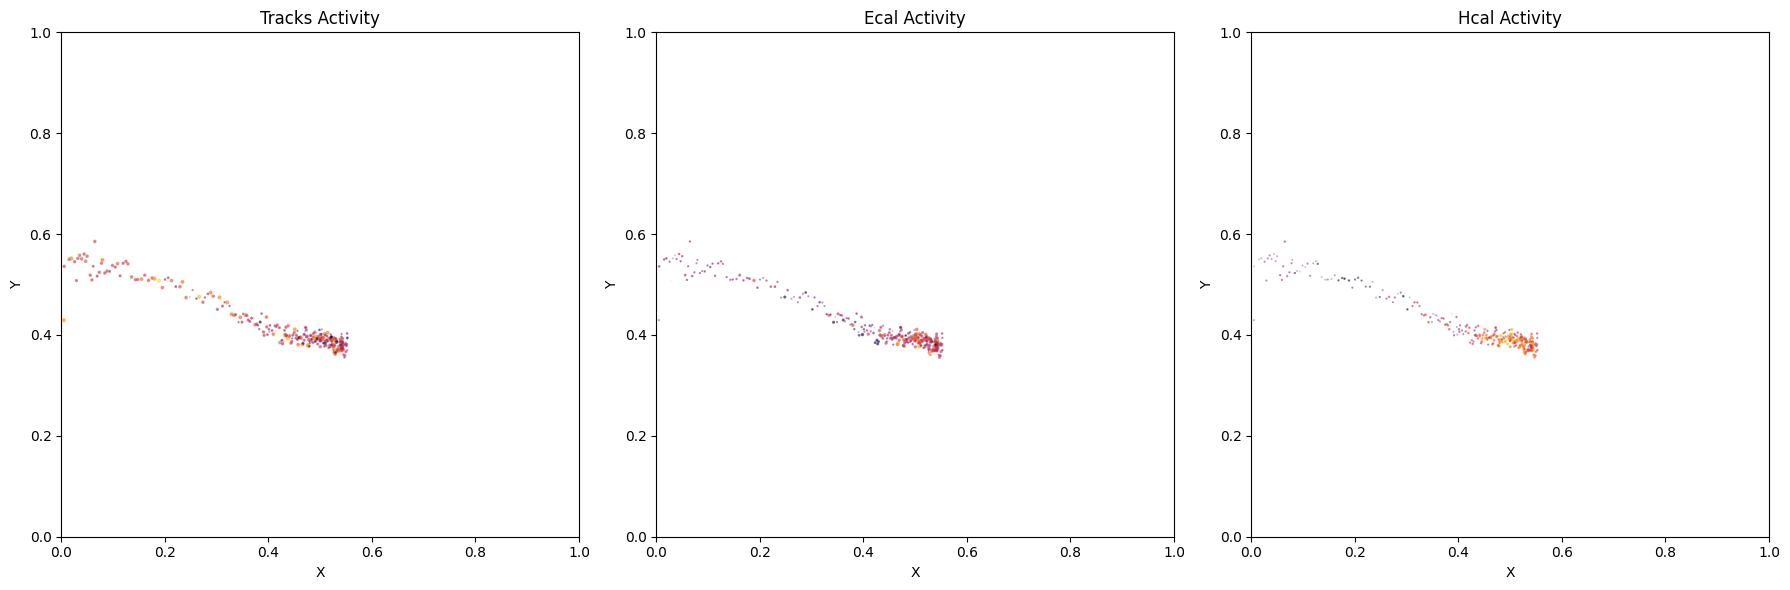

Inference:  75%|███████▌  | 3/4 [00:03<00:01,  1.13s/it]

SSIM Score: 0.9540446400642395


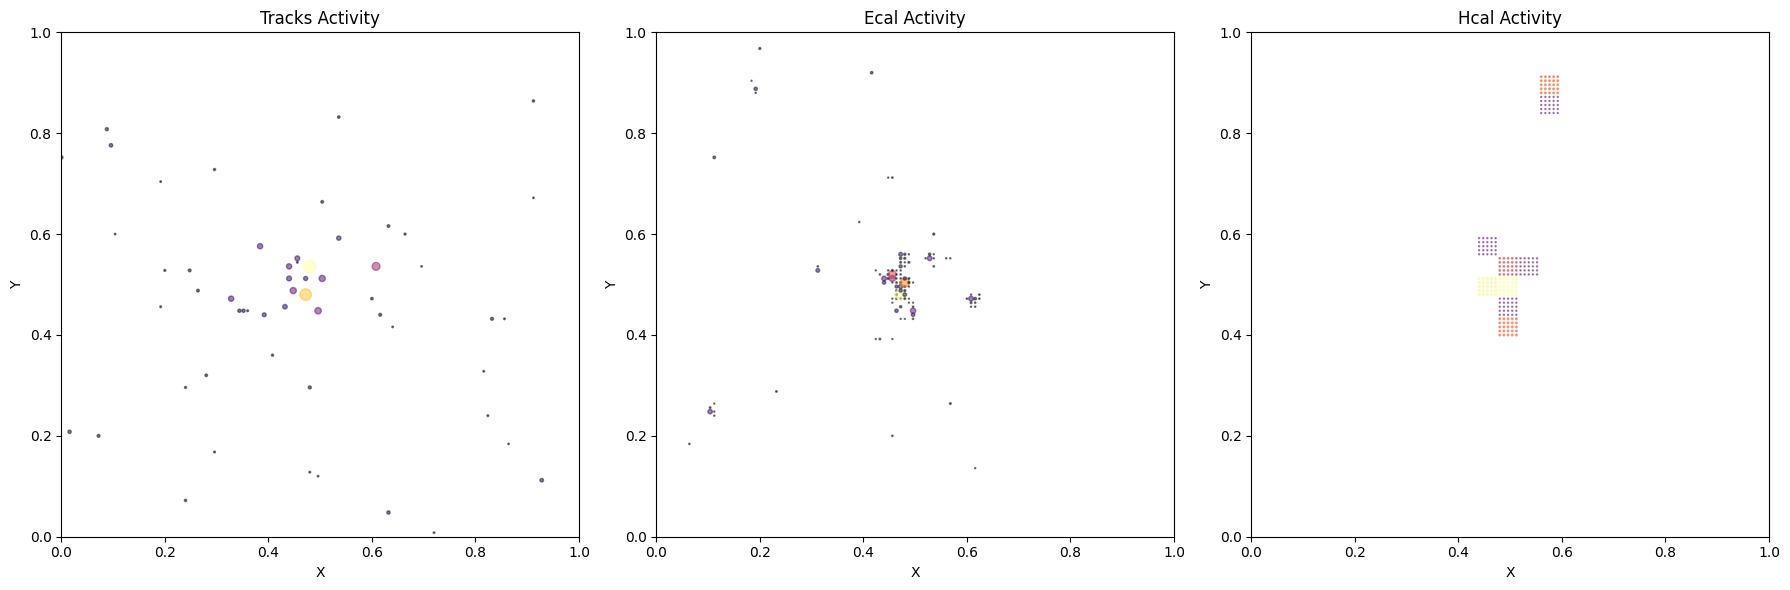

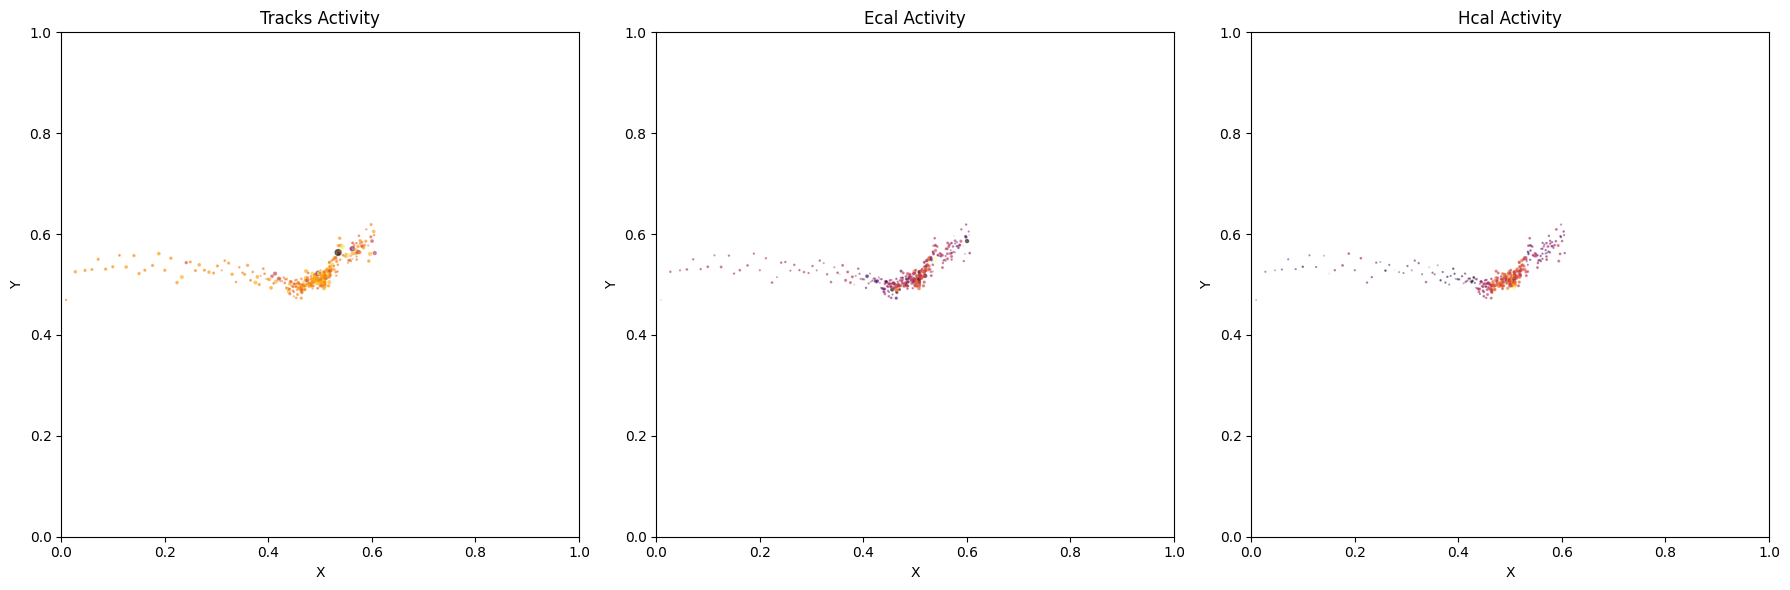

SSIM Score: 0.9546252489089966
Epoch :  30  Loss :  0.36720014380989596


Epoch :  31  Loss :  0.36754182865843177


Epoch :  32  Loss :  0.36744653148343787


Epoch :  33  Loss :  0.36526265839347616


Epoch :  34  Loss :  0.3657751535065472


Epoch :  35  Loss :  0.3649989479454234


Epoch :  36  Loss :  0.36272374010877684


Epoch :  37  Loss :  0.36301920824917033


Epoch :  38  Loss :  0.3631019930471666


Epoch :  39  Loss :  0.3620968206669204


Inference:   0%|          | 0/4 [00:00<?, ?it/s]                        

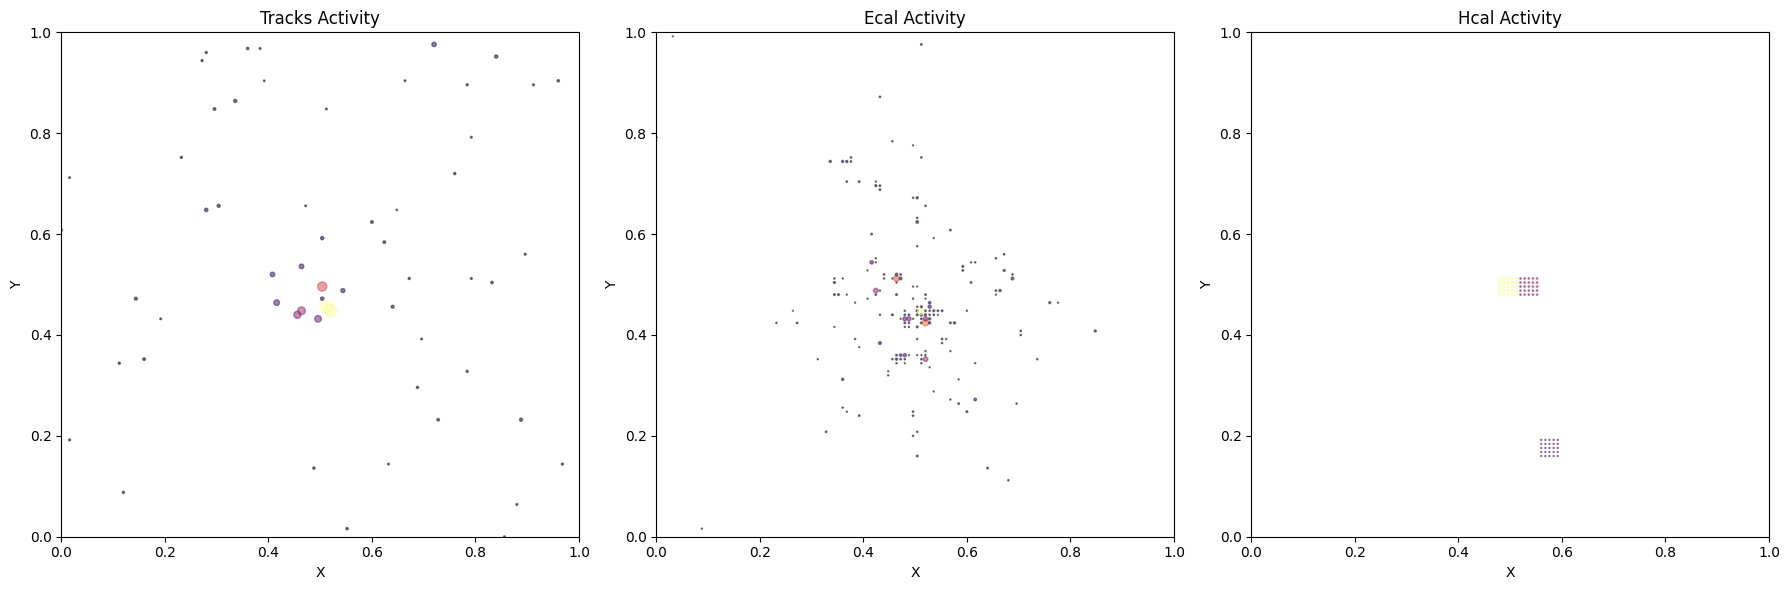

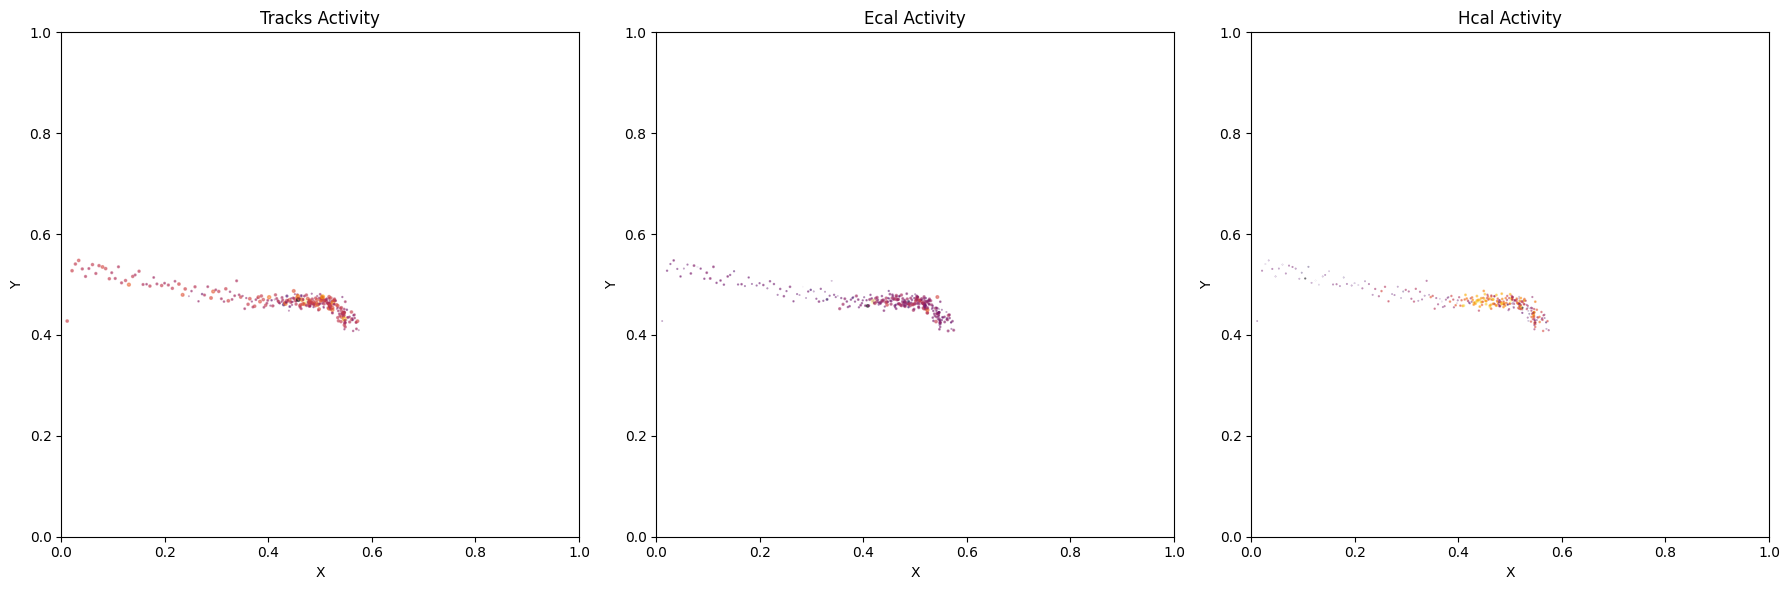

Inference:  25%|██▌       | 1/4 [00:01<00:03,  1.05s/it]

SSIM Score: 0.9604158401489258


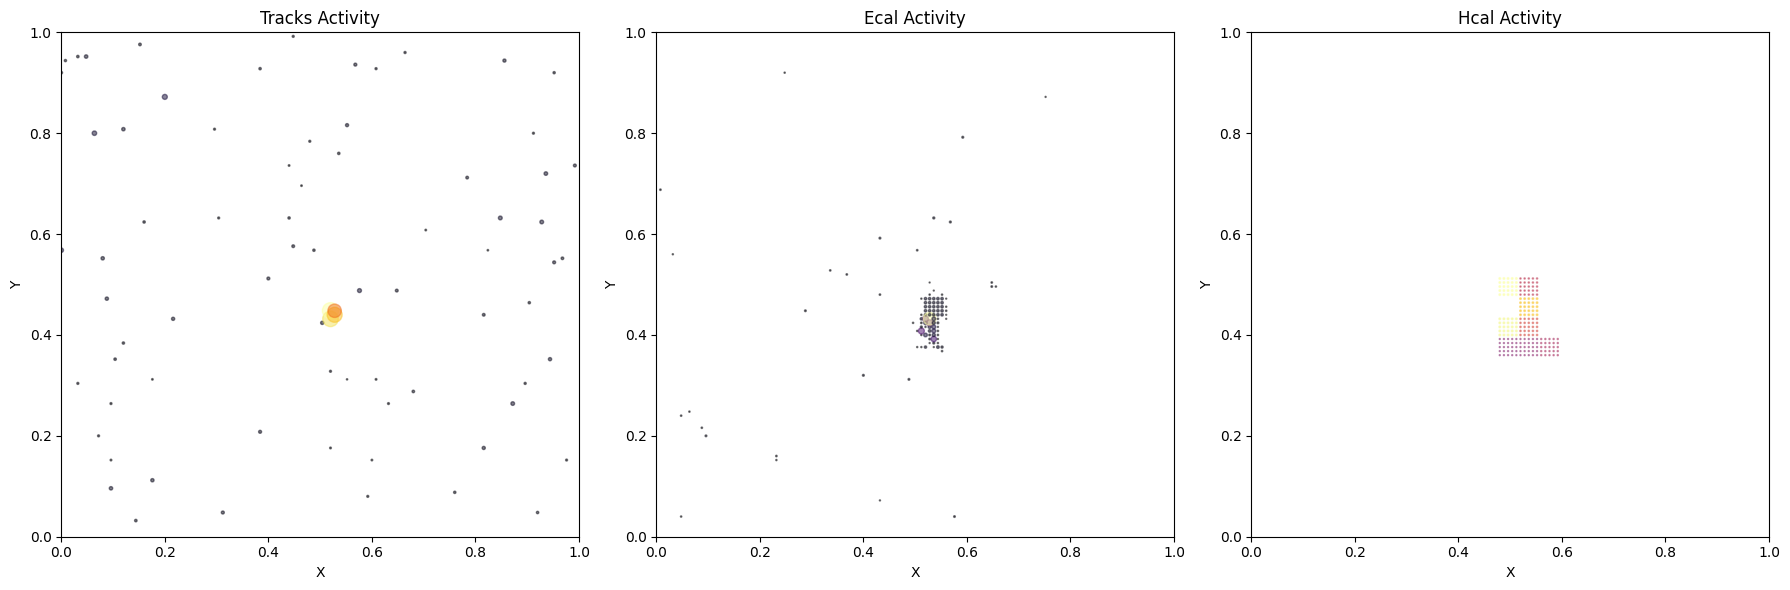

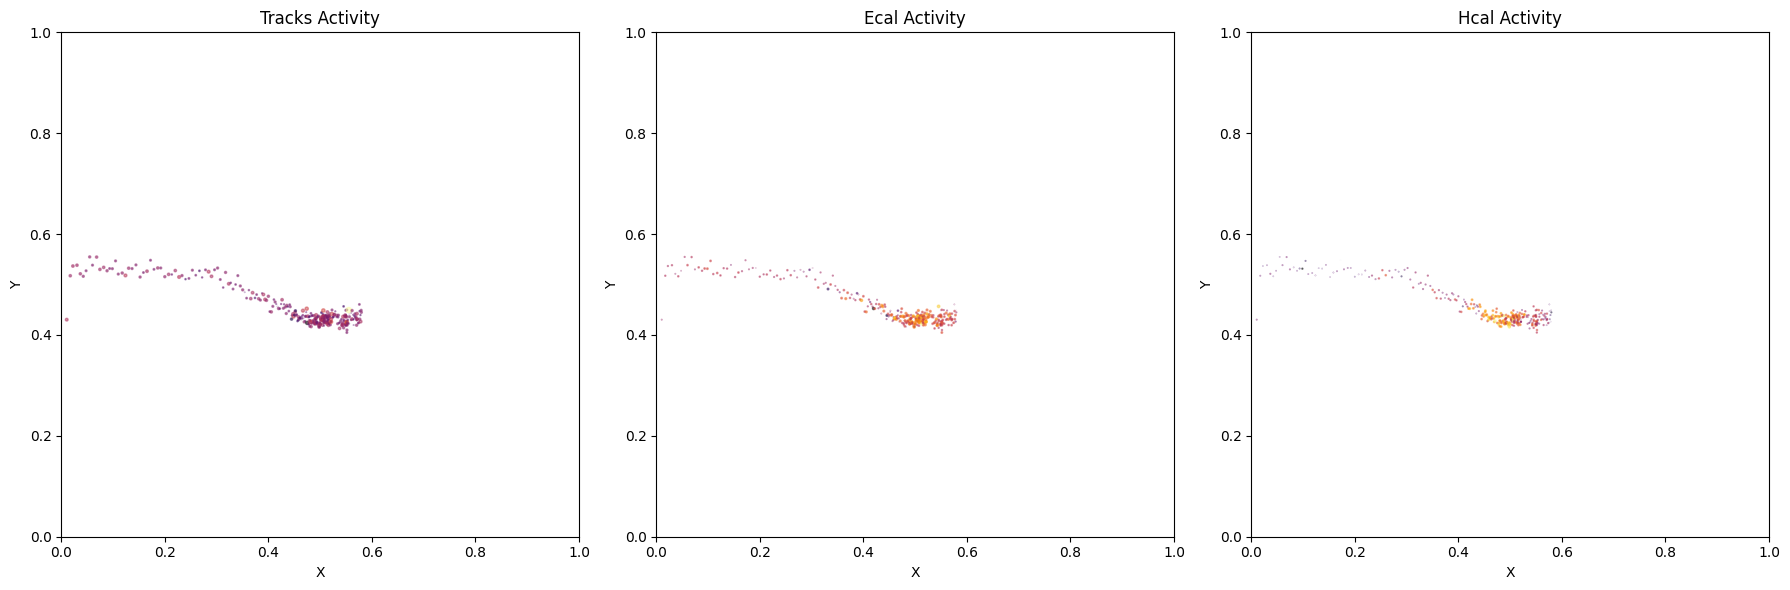

Inference:  50%|█████     | 2/4 [00:02<00:02,  1.04s/it]

SSIM Score: 0.9698946475982666


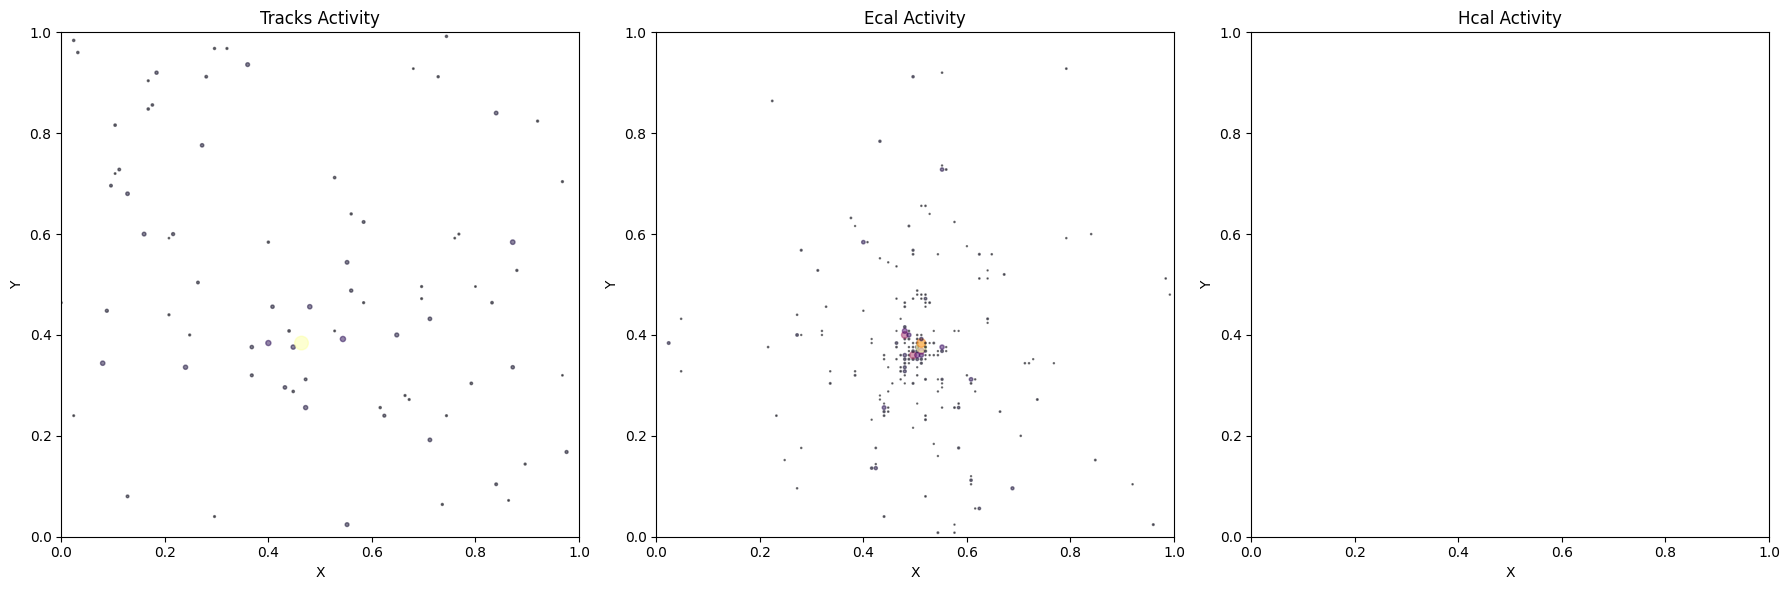

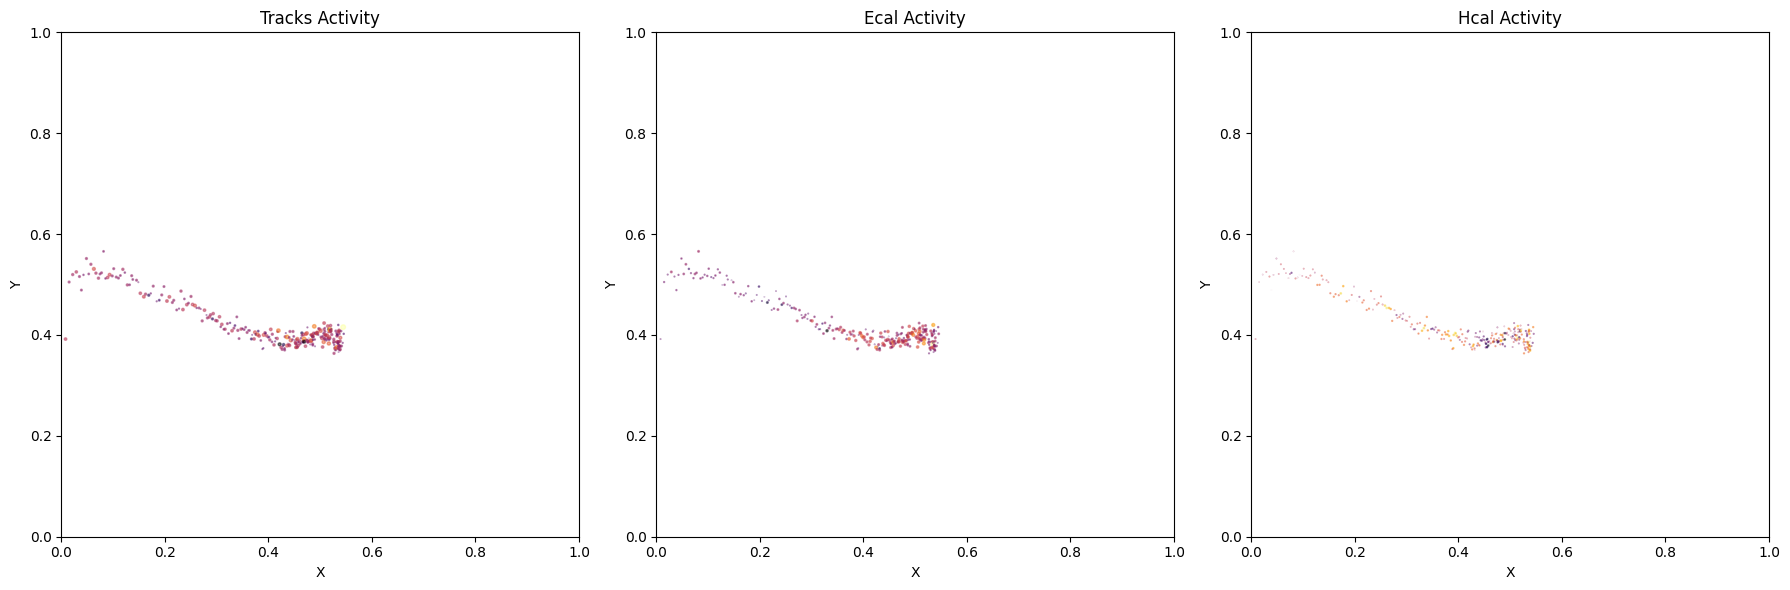

Inference:  75%|███████▌  | 3/4 [00:03<00:01,  1.04s/it]

SSIM Score: 0.962800145149231


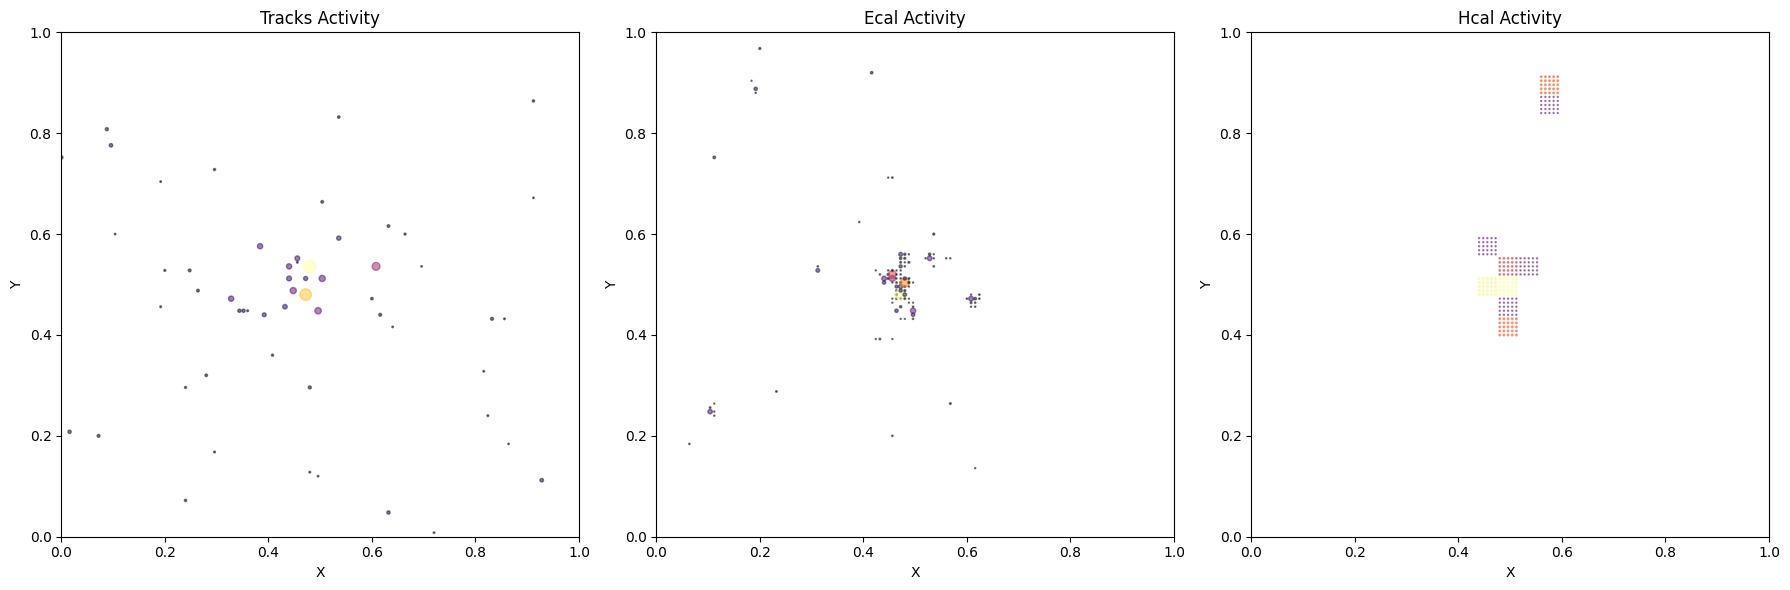

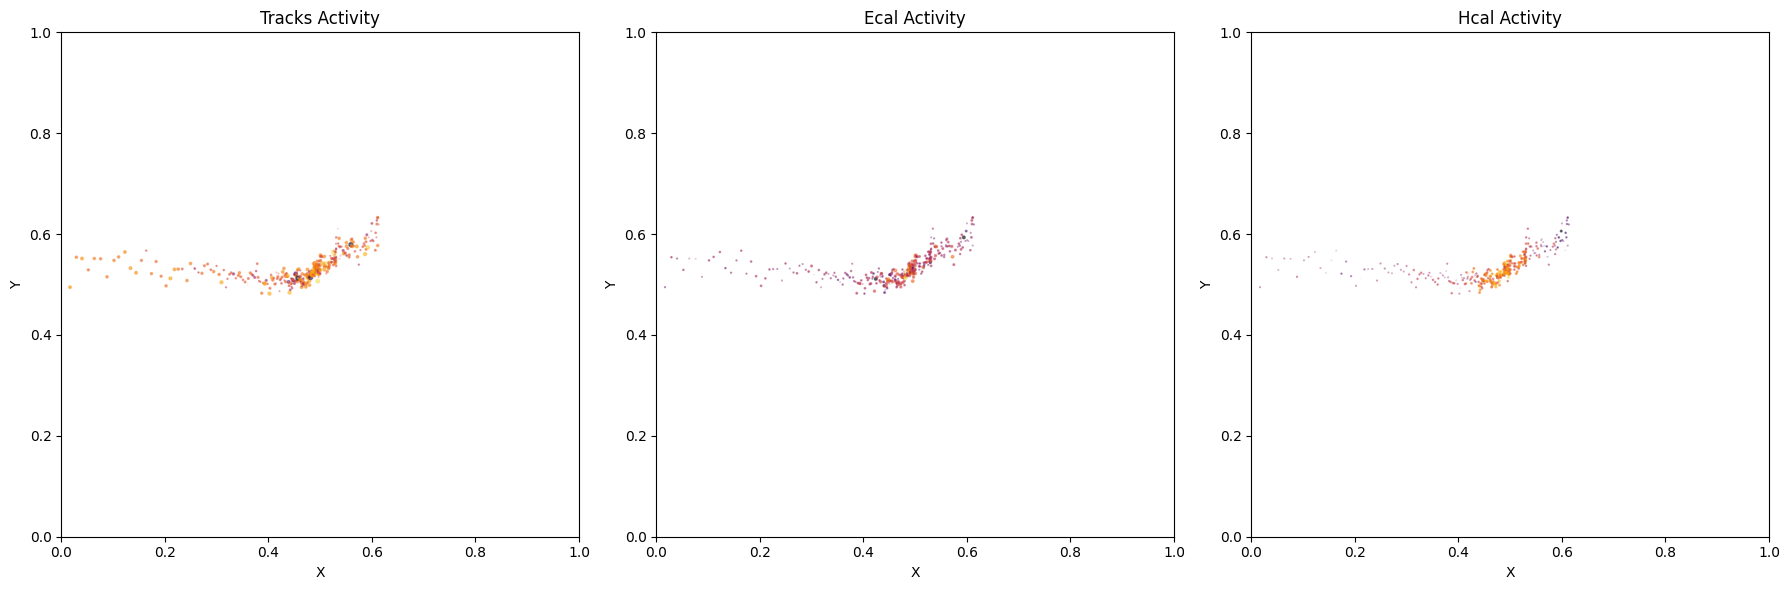

SSIM Score: 0.9509390592575073
Epoch :  40  Loss :  0.36183792422525585


Epoch :  41  Loss :  0.36205158807570115


Epoch :  42  Loss :  0.36113130825106055


Epoch :  43  Loss :  0.3591077043674886


Epoch :  44  Loss :  0.35901512764394283


Epoch :  45  Loss :  0.3582064629881643


Epoch :  46  Loss :  0.3587997148861177


Epoch :  47  Loss :  0.3599551059305668


Epoch :  48  Loss :  0.3572996624279767


Epoch :  49  Loss :  0.3567603591363877


Inference:   0%|          | 0/4 [00:00<?, ?it/s]                        

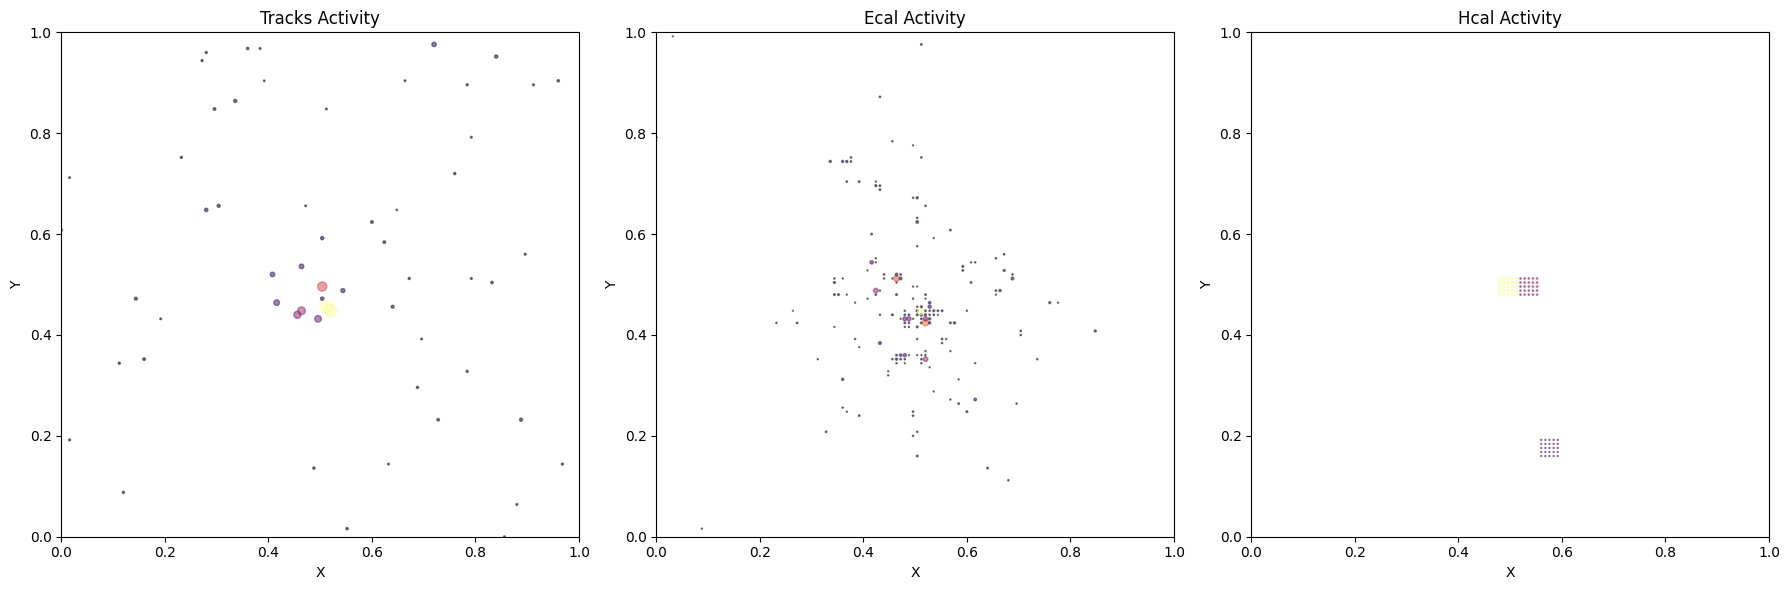

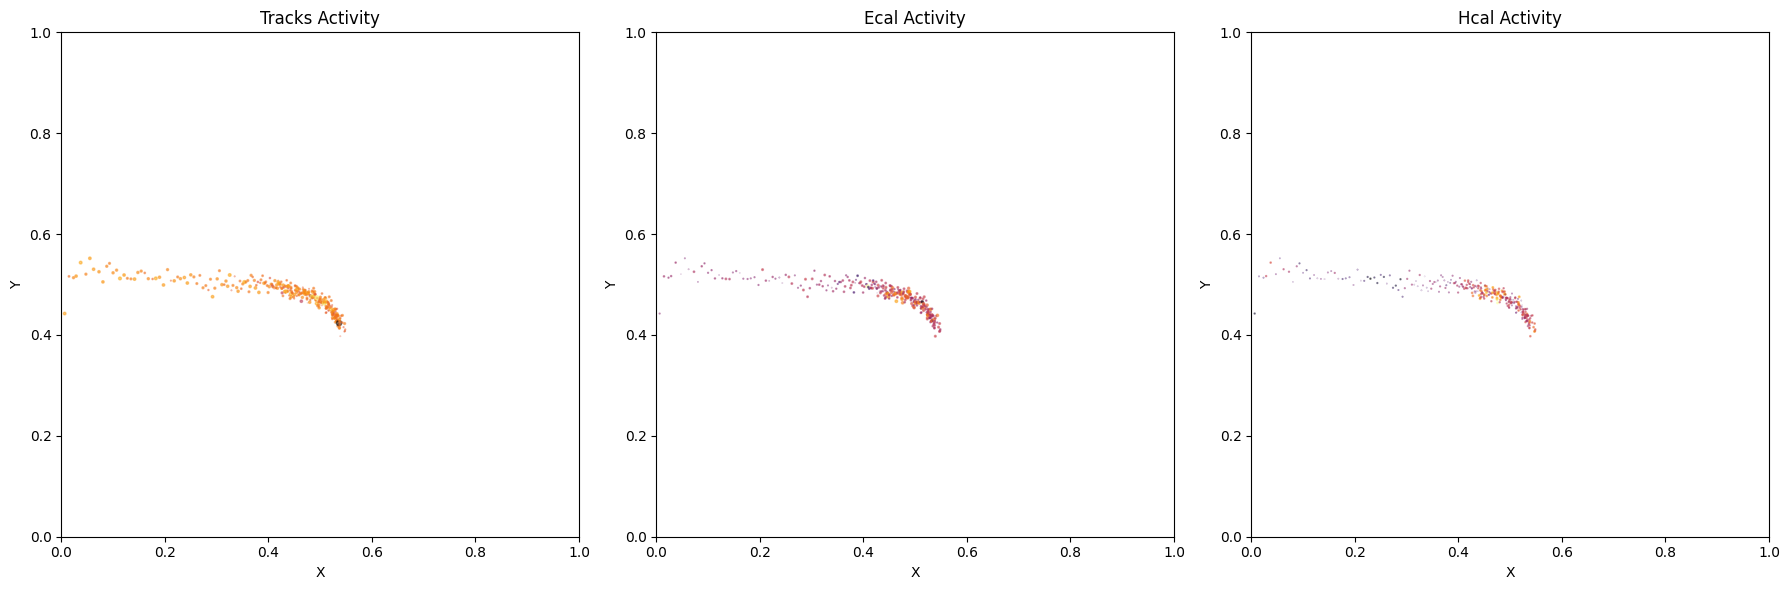

Inference:  25%|██▌       | 1/4 [00:01<00:03,  1.06s/it]

SSIM Score: 0.9613601565361023


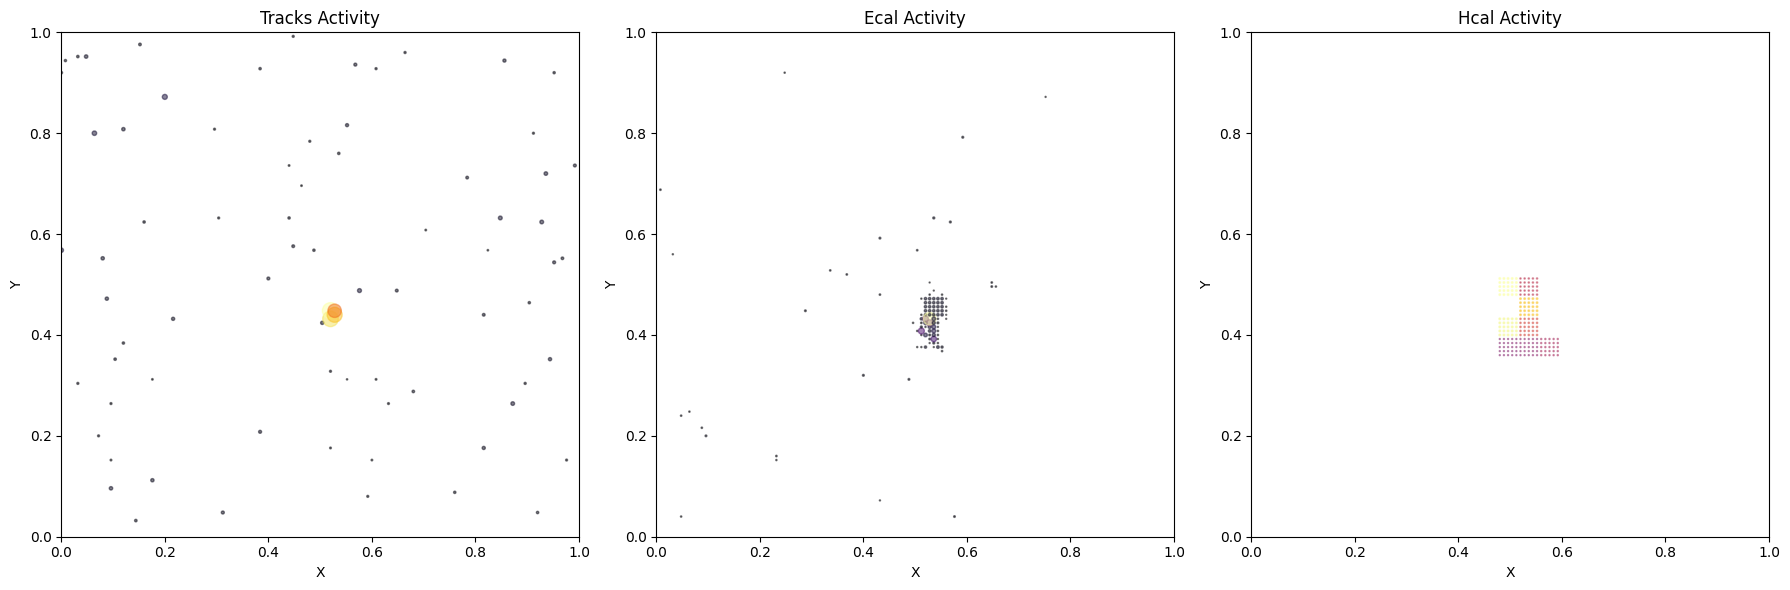

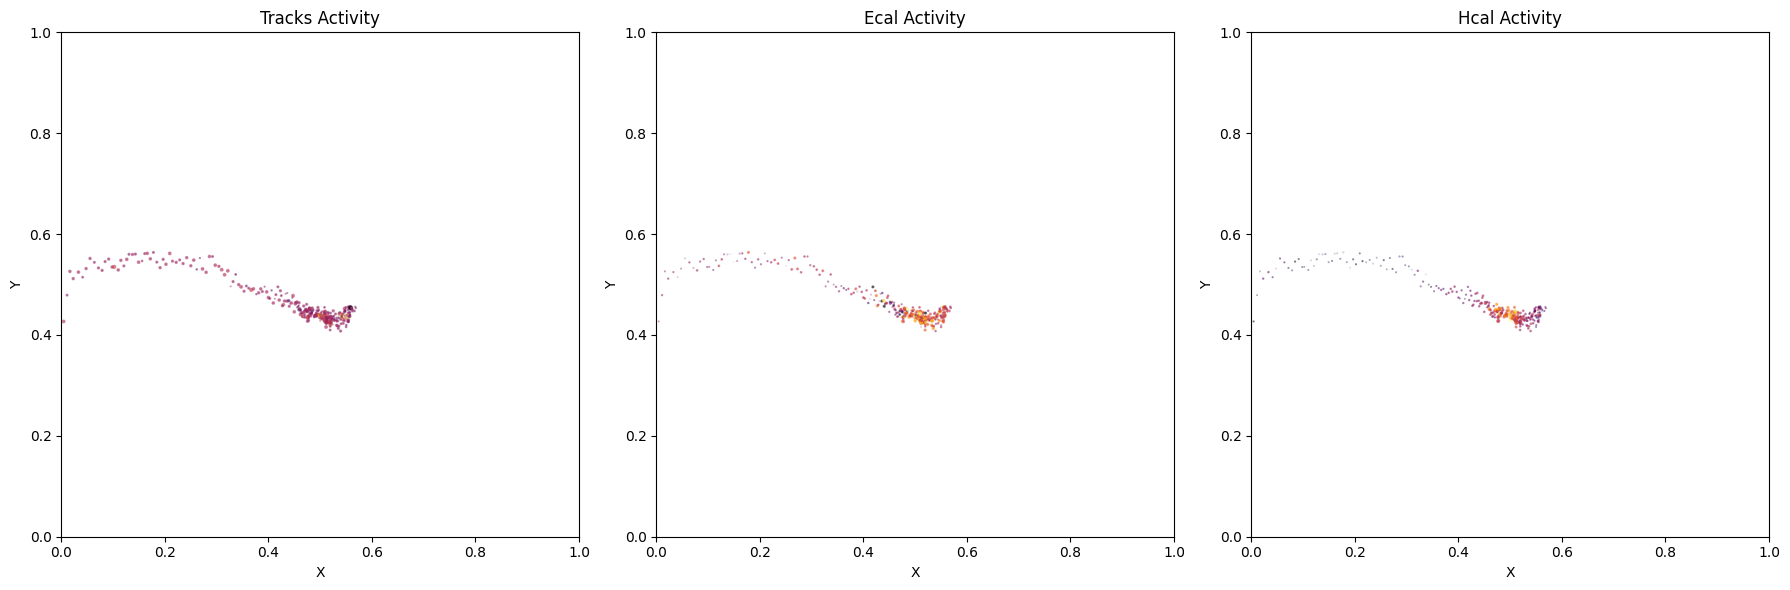

Inference:  50%|█████     | 2/4 [00:02<00:02,  1.37s/it]

SSIM Score: 0.9571297764778137


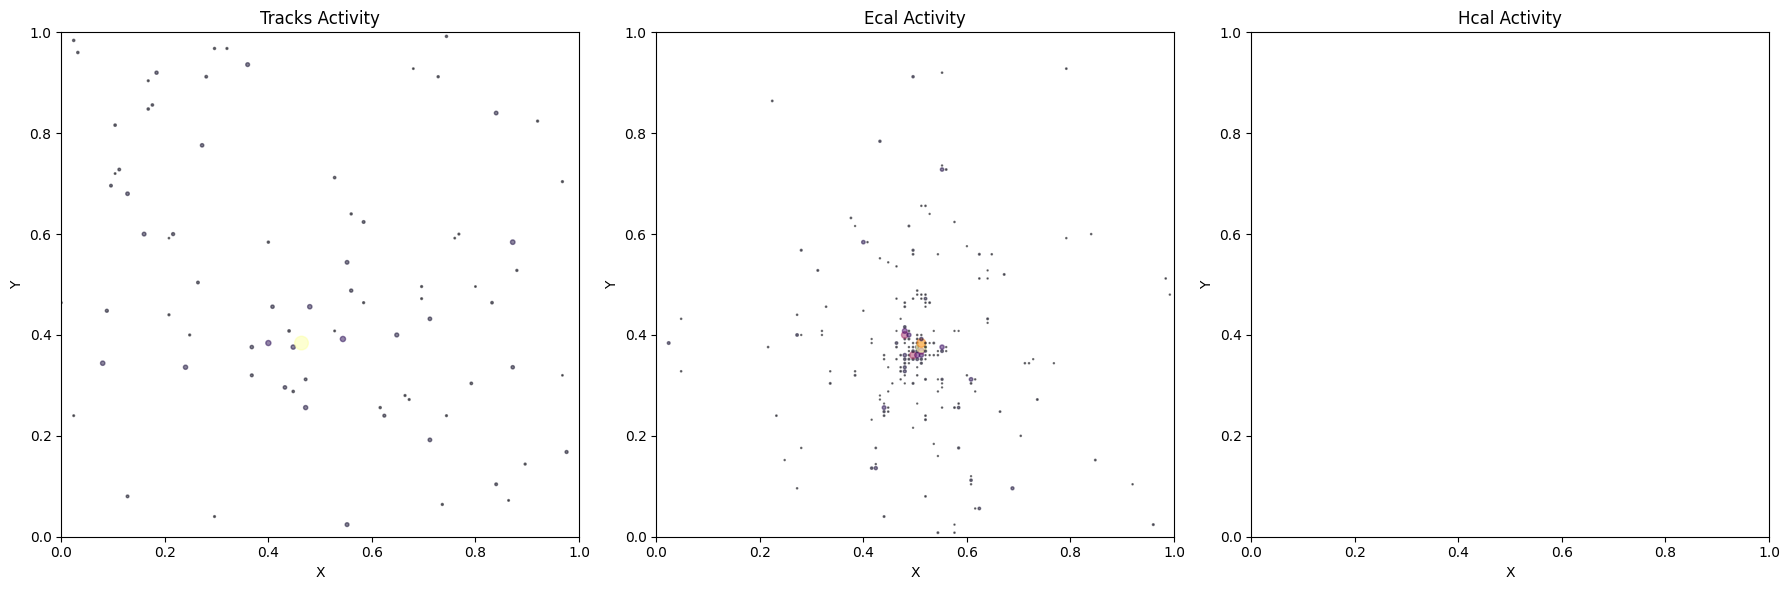

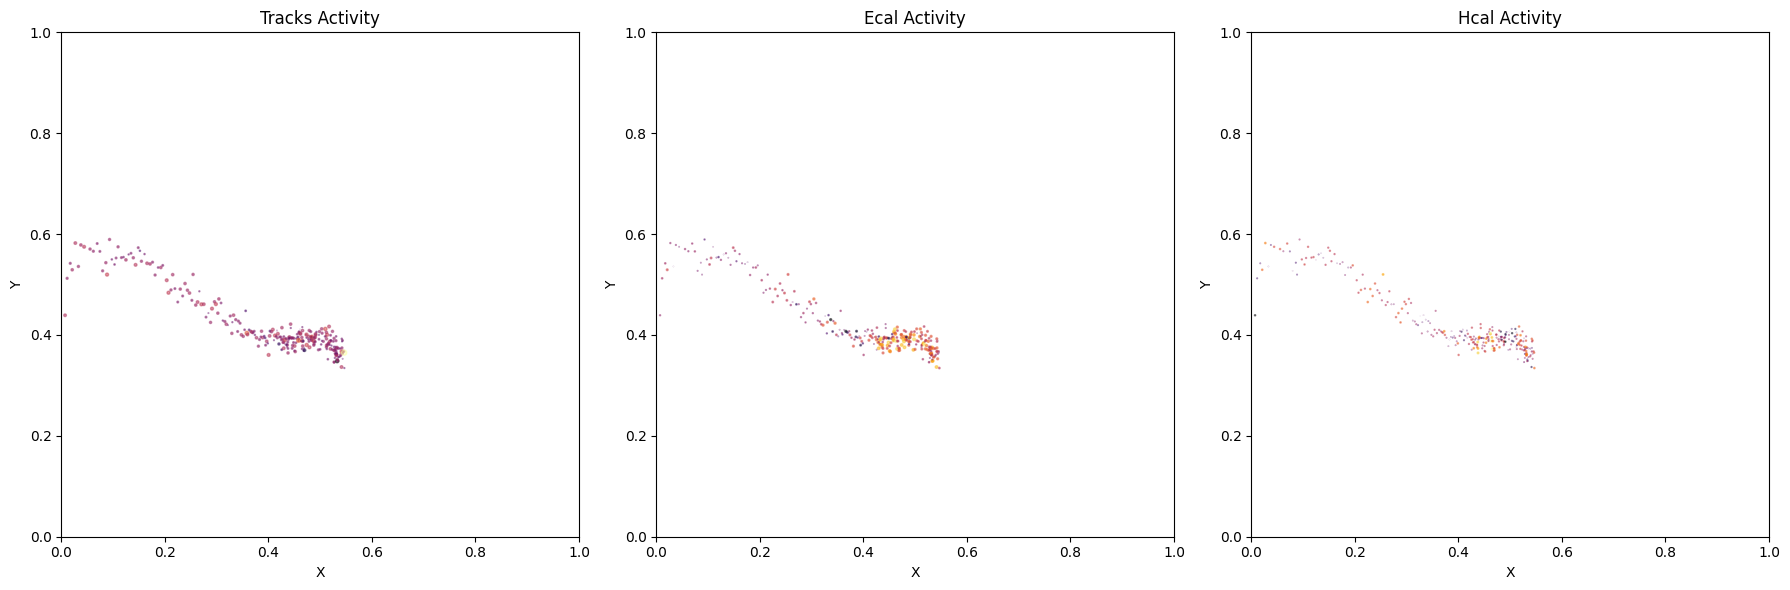

Inference:  75%|███████▌  | 3/4 [00:03<00:01,  1.23s/it]

SSIM Score: 0.9593967795372009


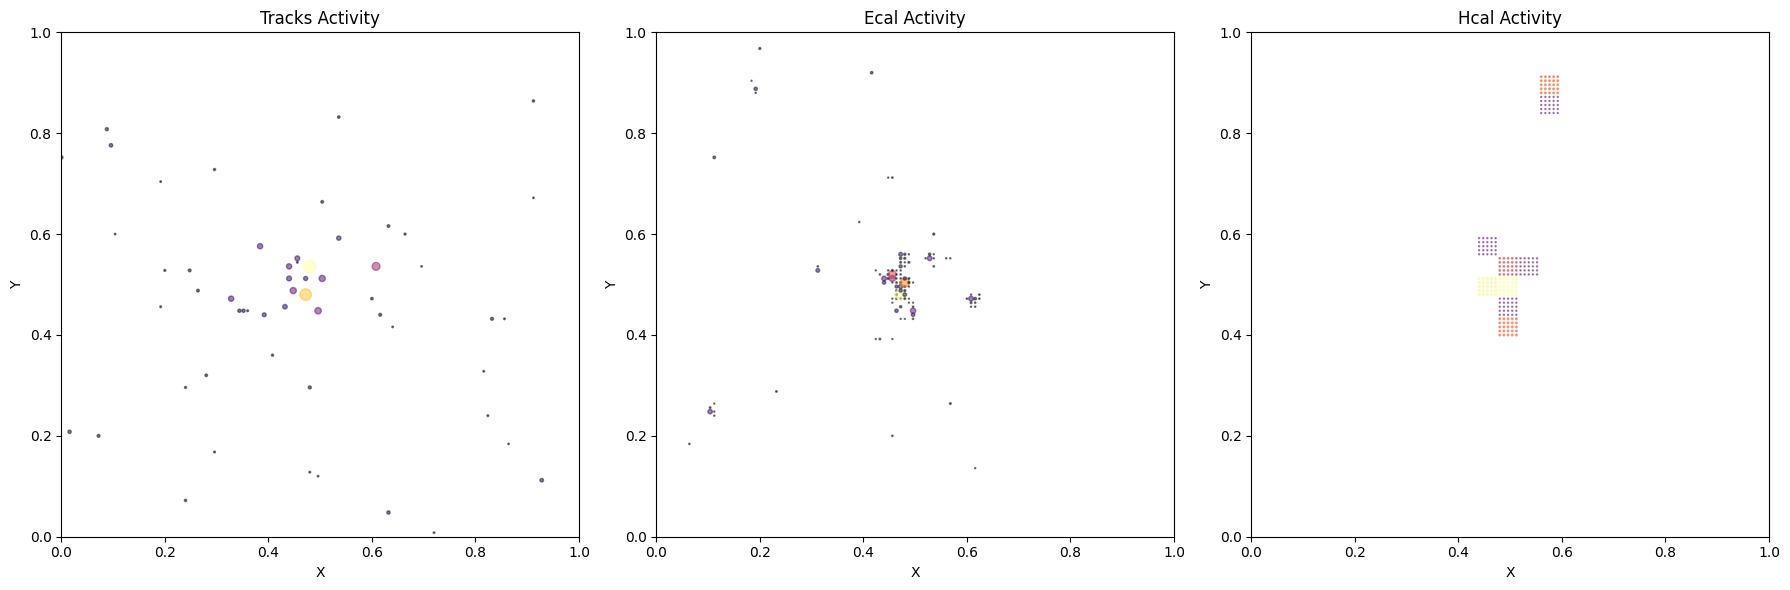

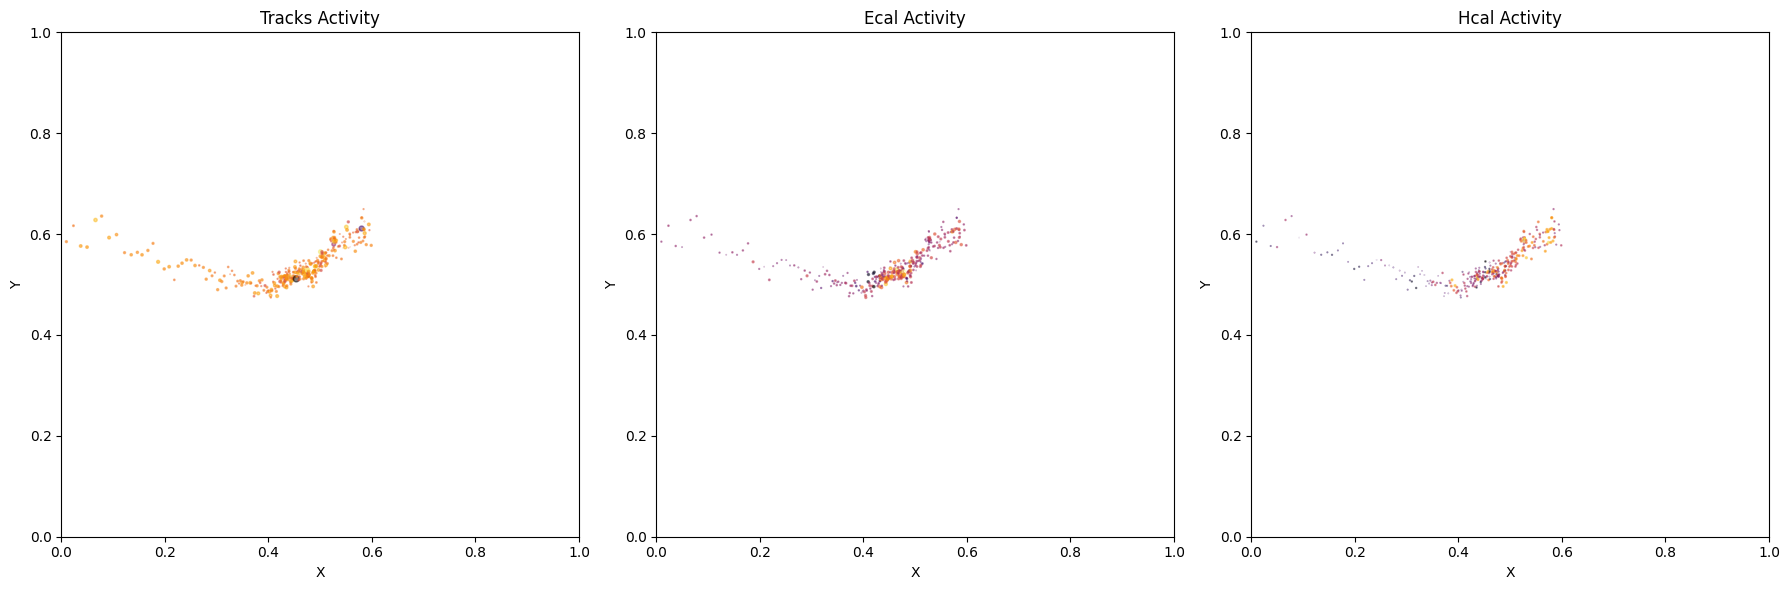

SSIM Score: 0.9552584886550903
Epoch :  50  Loss :  0.35717338463291526


In [127]:
model = GAE(5, 32)
#model = nn.DataParallel(model)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(50):
    loss = train()
    if (epoch + 1) % 10  == 0:
        inference(model, test_loader, device)
    print("Epoch : ", epoch + 1, " Loss : ", loss)

In [ ]:
torch.save(model, "task_3_GAE.pth")

In [ ]:
del train_loader
del test_loader
del val_loader

**Observations and Inferences**  

1. The model faced challenges in accurately reconstructing node features for graphs with varying node counts.  
2. Increasing the k value improved reconstruction quality by providing more context for each node, but this also led to denser graphs, making learning more complex.  
3. Coordinate-based sorting effectively simplified the loss calculation since a graph matching algorithm was not needed.  
4. Masking-based loss contributed to stable training across graphs with different sizes by focusing on the most relevant nodes.  
5. However, the canonical ordering introduced artifacts, notably a horizontal line of points. This occurred because the model learned the sorted ordering, and the mask consistently selected the first \( n \) nodes. 
6. Varying the layers or the individual channels weights in the loss calculations used did not cause any significant changes to the reconstructions
7. Structural Similarity Index Measure (SSIM) was used as the evaluation metric to assess the reconstruction quality, providing insight into how well the spatial structures were preserved.  